In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import scipy
import re
import random
import time
import os
from itertools import chain

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.spatial.distance import cdist


from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import roc_curve,RocCurveDisplay


from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize
from scipy.stats import spearmanr,rankdata,pearsonr


import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from statsmodels.stats.multitest import multipletests

pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_5_exports'
data_folder = '../all_data/Figure_5_data'


# Determining the threshold to differentiate between successfully and unsuccessfully made proteins

### Load and prepare data

In [22]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
data

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,SecYE,K,WCE,PEG,pmol,rxn_id,label
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.918,0.000,screen
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.311,0.000,screen
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,2.644,0.000,screen
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.546,0.000,screen
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.527,0.000,screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33542,eCM313,2.000,3.000,A1,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.149,3966.000,screen
33543,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3862.000,screen
33544,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3966.000,screen
33545,eCM313,2.000,4.000,G6,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,2.024,3862.000,screen


In [23]:
meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
meta = meta[~meta['DNA_name'].isin(['PPT1','AuxT1','FITM2'])]
comp = data.set_index('DNA_name').join(meta.set_index('DNA_name')).reset_index()
comp['ug_ml'] = (((comp['pmol']*10**-12)*comp['Mass']*10**9) / 2) * 1000
comp

,DNA_name,experiment_id,day,plate,well_name,Supp,DNA_conc,Liposome_name,Liposome_conc,Mg,...,PEG,pmol,rxn_id,label,uniprot,Organism,Length,tm_count,Mass,ug_ml
0,AqpZ,eCM313,1.000,1.000,H12,S22,5.000,DMPC,3,8.000,...,2.000,4.918,0.000,screen,P60844,E. coli,231,6,23.703,58.284
1,AqpZ,eCM313,1.000,1.000,K12,S22,5.000,DMPC,3,8.000,...,2.000,4.311,0.000,screen,P60844,E. coli,231,6,23.703,51.096
2,AqpZ,eCM313,1.000,1.000,M5,S22,5.000,DMPC,3,8.000,...,2.000,2.644,0.000,screen,P60844,E. coli,231,6,23.703,31.333
3,AqpZ,eCM313,2.000,4.000,J2,S22,5.000,DMPC,3,8.000,...,2.000,7.546,0.000,screen,P60844,E. coli,231,6,23.703,89.433
4,AqpZ,eCM313,2.000,4.000,N22,S22,5.000,DMPC,3,8.000,...,2.000,7.527,0.000,screen,P60844,E. coli,231,6,23.703,89.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,Vol,eCM313,2.000,3.000,A1,S22,5.000,no_lipo,0,20.000,...,2.000,1.149,3966.000,screen,Q5JW98,H. sapiens,314,4,35.060,20.135
11193,Vol,eCM313,2.000,4.000,B2,S22,5.000,no_lipo,0,20.000,...,2.000,1.265,3862.000,screen,Q5JW98,H. sapiens,314,4,35.060,22.171
11194,Vol,eCM313,2.000,4.000,B2,S22,5.000,no_lipo,0,20.000,...,2.000,1.265,3966.000,screen,Q5JW98,H. sapiens,314,4,35.060,22.171
11195,Vol,eCM313,2.000,4.000,G6,S22,5.000,no_lipo,0,20.000,...,2.000,2.024,3862.000,screen,Q5JW98,H. sapiens,314,4,35.060,35.481


In [24]:
sub_df = []
diff_threshold = 0.1

for rxn_id, df in comp.groupby('rxn_id'):
    t = df.copy()
    n_sub = np.mean(t[t['Liposome_conc'] == 0]['pmol'])
    
    t['pmol_sub_nolipo'] = t['pmol'] - n_sub
    # t['ugml_sub_nolipo'] = t['ug_ml'] - n_sub
    
    l = t[t['Liposome_conc'] != 0]
    n = t[t['Liposome_conc'] == 0]
    pval = ttest_ind(l['pmol_sub_nolipo'],n['pmol_sub_nolipo'])[1]

    t['p-val'] = pval
    mean_diff = np.mean(l['pmol_sub_nolipo'])
    t['mean_diff'] = mean_diff
    if mean_diff > diff_threshold and pval < 0.05:
        t['score'] = 1
    else:
        t['score'] = 0
    sub_df.append(t)

sub_df = pd.concat(sub_df).reset_index(drop=True)
sub_df

,DNA_name,experiment_id,day,plate,well_name,Supp,DNA_conc,Liposome_name,Liposome_conc,Mg,...,uniprot,Organism,Length,tm_count,Mass,ug_ml,pmol_sub_nolipo,p-val,mean_diff,score
0,AqpZ,eCM313,1.000,1.000,H12,S22,5.000,DMPC,3,8.000,...,P60844,E. coli,231,6,23.703,58.284,2.688,0.006,3.159,1
1,AqpZ,eCM313,1.000,1.000,K12,S22,5.000,DMPC,3,8.000,...,P60844,E. coli,231,6,23.703,51.096,2.081,0.006,3.159,1
2,AqpZ,eCM313,1.000,1.000,M5,S22,5.000,DMPC,3,8.000,...,P60844,E. coli,231,6,23.703,31.333,0.414,0.006,3.159,1
3,AqpZ,eCM313,2.000,4.000,J2,S22,5.000,DMPC,3,8.000,...,P60844,E. coli,231,6,23.703,89.433,5.316,0.006,3.159,1
4,AqpZ,eCM313,2.000,4.000,N22,S22,5.000,DMPC,3,8.000,...,P60844,E. coli,231,6,23.703,89.205,5.297,0.006,3.159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,Vol,eCM313,1.000,2.000,C22,S22,5.000,no_lipo,0,20.000,...,Q5JW98,H. sapiens,314,4,35.060,33.577,0.238,0.095,-0.415,0
11193,Vol,eCM313,1.000,2.000,N11,S22,5.000,no_lipo,0,20.000,...,Q5JW98,H. sapiens,314,4,35.060,26.805,-0.148,0.095,-0.415,0
11194,Vol,eCM313,2.000,3.000,A1,S22,5.000,no_lipo,0,20.000,...,Q5JW98,H. sapiens,314,4,35.060,20.135,-0.529,0.095,-0.415,0
11195,Vol,eCM313,2.000,4.000,B2,S22,5.000,no_lipo,0,20.000,...,Q5JW98,H. sapiens,314,4,35.060,22.171,-0.413,0.095,-0.415,0


In [25]:
len(sub_df['DNA_name'].unique())

28

### Set the threshold for successful synthesis
* The threshold is based on both the magnitude of the difference between the liposome and no liposome reaction and the significance of that change
    * Must have p-value below 0.05
    * Must have a mean difference of greater or equal to 1
* The criteria requires that only a single reaction composition clear the thresholds for a protein to be considered successfully synthesized

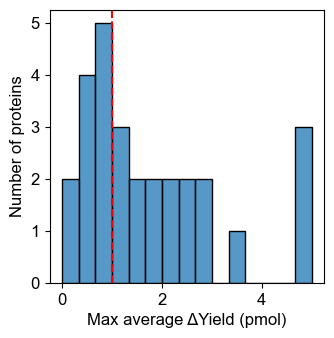

['B2AR', 'B3AR', 'CD63', 'CD81', 'CML1', 'Cx43', 'FFAR4', 'Neu', 'OR1D2', 'OR1E1', 'OR2AG1']
11


In [26]:
plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

significance_threshold = 0.05
# difference_threshold = 20
difference_threshold = 1

temp = sub_df[sub_df['Liposome_name'] != 'no_lipo'].drop_duplicates(subset=['rxn_id'])
temp = temp[['DNA_name','mean_diff','p-val','score']]
temp = temp[temp['p-val'] < significance_threshold]
temp = temp.groupby('DNA_name')[['mean_diff']].agg('max').reset_index()
temp['mean_diff_clipped'] = temp['mean_diff'].clip(0,5)
sns.histplot(temp,x='mean_diff_clipped',ax=ax,bins=15)
plt.axvline(difference_threshold,c='r',ls='--',lw=1.5)
plt.xlabel('Max average ΔYield (pmol)')
plt.ylabel('Number of proteins')
# plt.savefig(f'{fig_folder}/Supp_fig-separation_good_bad.svg',format='svg',dpi=300)

# temp.set_index('DNA_name').to_excel(f'{data_folder}/Supp_fig-separation_good_bad.xlsx')
plt.show()
low = temp[temp['mean_diff'] <= difference_threshold]['DNA_name'].tolist()
print(low)
print(len(low))
plt.rcParams['font.size'] = 7


### Apply multiple hypothesis testing to determine which proteins were successfully synthesized
- Uses the Benjamini-Hochberg method to calculate the False Discovery Rate (FDR) to correct the p-values used to assess successful synthesis of a protein

In [27]:
def apply_multiple_testing_correction(df, alpha=0.05, method='fdr_bh'):
    corrected_pvals = {}
    # Group the data by protein
    for protein, group in df.groupby('DNA_name'):
        p_values = group['p-val'].values
        # Apply the multiple testing correction
        _, corrected_pvals[protein], _, _ = multipletests(p_values, alpha=alpha, method=method)
        
        # Add corrected p-values to the DataFrame
        df.loc[group.index, 'Corrected_P_value'] = corrected_pvals[protein]
    
    return df

lipo = sub_df[sub_df['Liposome_name'] != 'no_lipo']
df_corrected = apply_multiple_testing_correction(lipo[['DNA_name', 'p-val','mean_diff']].copy())
df_corrected

def determine_success(df, p_value_threshold=0.05, yield_difference_threshold=1.0):
    df['Success'] = (df['Corrected_P_value'] < p_value_threshold) & (df['mean_diff'] > yield_difference_threshold)
    df['Success-original'] = (df['p-val'] < p_value_threshold) & (df['mean_diff'] > yield_difference_threshold)
    
    # Summarize success for each protein
    success_summary = df.groupby('DNA_name')['Success'].any().reset_index()
    success_summary_original = df.groupby('DNA_name')['Success-original'].any().reset_index()

    full_summary = success_summary.merge(success_summary_original,on='DNA_name')
    return full_summary

# Determine success based on corrected p-values
success_summary = determine_success(df_corrected)
success_summary['comparison'] = success_summary['Success'] == success_summary['Success-original']
success_summary[success_summary['comparison'] == False]

low = success_summary[success_summary['Success'] == False]['DNA_name'].tolist()
low


['B2AR',
 'B3AR',
 'CD63',
 'CD81',
 'CML1',
 'CRCM',
 'Cx43',
 'FFAR4',
 'Neu',
 'OR1D2',
 'OR1E1',
 'OR2AG1']

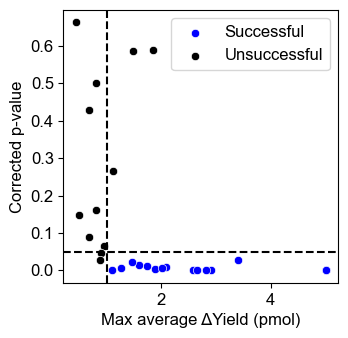

In [28]:
sig = df_corrected[df_corrected['Success'] == True]
sig_max = []
for prot, prot_df in sig.groupby('DNA_name'):
    prot_df = prot_df.sort_values('mean_diff',ascending=False)
    sig_max.append(prot_df.iloc[0])

sig = pd.DataFrame(sig_max)

insig = df_corrected[df_corrected['DNA_name'].isin(low)]
insig_max = []
for prot, prot_df in insig.groupby('DNA_name'):
    prot_df = prot_df.sort_values('mean_diff',ascending=False)
    insig_max.append(prot_df.iloc[0])

insig = pd.DataFrame(insig_max)
insig

export = pd.concat([sig,insig])
export[['DNA_name', 'p-val', 'mean_diff', 'Corrected_P_value']].set_index('DNA_name').to_excel(f'{data_folder}/Supp_fig-separation_good_bad.xlsx')

plt.rcParams['font.size'] = 12
fig,ax = plt.subplots(figsize=[9*cm,9*cm])

sig['mean_diff'] = sig['mean_diff'].clip(0,5)

sns.scatterplot(data=sig,x='mean_diff',y='Corrected_P_value',ax=ax,label='Successful',c='b')
sns.scatterplot(data=insig,x='mean_diff',y='Corrected_P_value',ax=ax,label='Unsuccessful',c='k')
plt.axhline(0.05,c='k',ls='--',lw=1.5)
plt.axvline(1,c='k',ls='--',lw=1.5)
plt.xlabel('Max average ΔYield (pmol)')
plt.ylabel('Corrected p-value')
# plt.savefig(f'{fig_folder}/Supp_fig-scatter_separation_good_bad.svg',format='svg',dpi=300)

plt.show()
plt.rcParams['font.size'] = 7


In [169]:
export.columns
# sub_df

Index(['DNA_name', 'p-val', 'mean_diff', 'Corrected_P_value', 'Success',
       'Success-original'],
      dtype='object')

# Generate embeddings for different subsets of protein features

### Read in and join all data
* Includes the annotations for the complete dataset
* The summarized calculations for all proteins
* The list of proteins that were actually tested

In [9]:
anno_df = pd.read_pickle(data_folder+'/annotated_targets.pkl')


In [10]:
calcs = pd.read_excel(data_folder+'/uniprot_ids_metrics.xlsx')

In [11]:
meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
meta = meta[~meta['DNA_name'].isin(['PPT1','AuxT1','FITM2'])]
meta = meta.rename(columns={'DNA_name':'Protein name'})

In [12]:
all_df = calcs.set_index('uniprot').join(anno_df.set_index('Uniprot'))
all_df = all_df.join(meta[['uniprot','Protein name']].set_index('uniprot')).reset_index()
all_df = all_df.fillna('other')

### Generate the list of columns to include in each experiment
* Creates all combinations of features within a given group like the layer or metric

In [13]:
options = ['charge','hydrophobicity','depth_6','prob']
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))

all_metrics = powerset(['charge','hydrophobicity','depth_6','prob'])
all_metrics = [list(c) for c in all_metrics]
all_metrics = [[i,c] for i,c in enumerate(all_metrics)] 
metric_df = pd.DataFrame(all_metrics,columns=['met_id','metrics'])

all_layers = powerset(['inner','outer','polar','interface','water'])
all_layers = [list(c) for c in all_layers]
all_layers = [[i,c] for i,c in enumerate(all_layers)] 
layer_df = pd.DataFrame(all_layers,columns=['layer_id','layers'])

all_shells = powerset(['inside','membrane','outside'])
all_shells = [list(c) for c in all_shells]
all_shells = [[i,c] for i,c in enumerate(all_shells)] 
shell_df = pd.DataFrame(all_shells,columns=['shell_id','shells'])
shell_df


,shell_id,shells
0,0,[inside]
1,1,[membrane]
2,2,[outside]
3,3,"[inside, membrane]"
4,4,"[inside, outside]"
5,5,"[membrane, outside]"
6,6,"[inside, membrane, outside]"


### Combinatorially mix the possible subsets of each sub-feature set

In [14]:
original_cols = [c for c in all_df.columns if '-' in c and ' ' not in c]

def get_col_list(row):
    layer_cols = []
    for layer in row['layers']:
        layer_cols += [c for c in original_cols if layer in c]
    
    shell_cols = []
    for shell in row['shells']:
        shell_cols += [c for c in layer_cols if shell in c]

    metric_cols = []
    for metric in row['metrics']:
        metric_cols += [c for c in shell_cols if metric in c]
    
    temp_cols = [c for c in metric_cols if 'Mean' in c]
    
    return temp_cols
    

all_combos = list(itertools.product(*[layer_df['layer_id'].tolist(),shell_df['shell_id'].tolist(),metric_df['met_id'].tolist()]))
all_combos = pd.DataFrame(all_combos,columns=['layer_id','shell_id','met_id'])
all_combos = all_combos.set_index('layer_id').join(layer_df.set_index('layer_id')).reset_index()
all_combos = all_combos.set_index('shell_id').join(shell_df.set_index('shell_id')).reset_index()
all_combos = all_combos.set_index('met_id').join(metric_df.set_index('met_id')).reset_index()
all_combos = all_combos[['layers','shells','metrics']]
all_combos['col_list'] = all_combos.apply(get_col_list,axis=1)

all_combos['num_features'] = all_combos['col_list'].apply(lambda x: len(x))
all_combos = all_combos[all_combos['num_features'] > 1].copy()

all_combos

,layers,shells,metrics,col_list,num_features
4,[inner],[inside],"[charge, hydrophobicity]","[inner-inside-charge-Mean, inner-inside-hydrop...",2
5,[inner],[inside],"[charge, depth_6]","[inner-inside-charge-Mean, inner-inside-depth_...",2
6,[inner],[inside],"[charge, prob]","[inner-inside-charge-Mean, inner-inside-prob-M...",2
7,[inner],[inside],"[hydrophobicity, depth_6]","[inner-inside-hydrophobicity-Mean, inner-insid...",2
8,[inner],[inside],"[hydrophobicity, prob]","[inner-inside-hydrophobicity-Mean, inner-insid...",2
...,...,...,...,...,...
3250,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6]","[inner-inside-charge-Mean, outer-inside-charge...",30
3251,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, prob]","[inner-inside-charge-Mean, outer-inside-charge...",30
3252,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[charge, depth_6, prob]","[inner-inside-charge-Mean, outer-inside-charge...",30
3253,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[hydrophobicity, depth_6, prob]","[inner-inside-hydrophobicity-Mean, outer-insid...",30


### Specify the metadata required to fully define the tSNE
* The seed must be specified to get the same result
* The perplexity value must also be set
    * Teh default is 30. I tried down to 5 and up to 50 and found that the results remained mostly unchanged so I left it as the default

In [15]:
full_col_df = all_combos.copy()

full_col_df['rep'] = 1

full_col_df = full_col_df.reset_index(drop=True).reset_index().rename(columns={'index':'id_num'})
full_col_df['seed'] = full_col_df['rep'] * full_col_df['id_num'] * 3
full_col_df['perp'] = 30


full_col_df

,id_num,layers,shells,metrics,col_list,num_features,rep,seed,perp
0,0,[inner],[inside],"[charge, hydrophobicity]","[inner-inside-charge-Mean, inner-inside-hydrop...",2,1,0,30
1,1,[inner],[inside],"[charge, depth_6]","[inner-inside-charge-Mean, inner-inside-depth_...",2,1,3,30
2,2,[inner],[inside],"[charge, prob]","[inner-inside-charge-Mean, inner-inside-prob-M...",2,1,6,30
3,3,[inner],[inside],"[hydrophobicity, depth_6]","[inner-inside-hydrophobicity-Mean, inner-insid...",2,1,9,30
4,4,[inner],[inside],"[hydrophobicity, prob]","[inner-inside-hydrophobicity-Mean, inner-insid...",2,1,12,30
...,...,...,...,...,...,...,...,...,...
2936,2936,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6]","[inner-inside-charge-Mean, outer-inside-charge...",30,1,8808,30
2937,2937,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, prob]","[inner-inside-charge-Mean, outer-inside-charge...",30,1,8811,30
2938,2938,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[charge, depth_6, prob]","[inner-inside-charge-Mean, outer-inside-charge...",30,1,8814,30
2939,2939,"[inner, outer, polar, interface, water]","[inside, membrane, outside]","[hydrophobicity, depth_6, prob]","[inner-inside-hydrophobicity-Mean, outer-insid...",30,1,8817,30


In [16]:
full_col_df.value_counts('num_features')

num_features
4     519
6     500
2     474
3     308
8     281
     ... 
27      4
28      4
30      4
36      1
40      1
Name: count, Length: 23, dtype: int64

### Calculate all the tSNE reduced XY points
* Initially normalize all data using a standard scaler, this can be done on the full set and then pulled from for the subsets

In [80]:
time_start = time.strftime("%Y-%m-%d_%H-%M", time.gmtime())

dir_path = f'./all_tSNE_data/set_{set_num}_data'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
else:
    print('Directory already exists - Overwriting data')


for i,row in full_col_df.iterrows():
    target_path = f'{dir_path}/id_num-{row.id_num}.pkl'
    if os.path.exists(target_path):
        print(f'{target_path} already exists')
        continue
    scaled = np.array(all_df[row['col_list']])
    scaler = StandardScaler()
    X_train = scaler.fit_transform(scaled)
    
    tsne = TSNE(random_state=row['seed'], perplexity=row['perp'])
    X_tsne = tsne.fit_transform(np.array(X_train))
    tsne = pd.DataFrame(X_tsne,columns=['x','y'])
    tsne['uniprot'] = all_df['uniprot']
    tsne['id_num'] = row['id_num']
    tsne.to_pickle(f'{dir_path}/id_num-{row.id_num}.pkl')

    print(i,'current time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))

print('Start time: ',time_start)
print('End time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))

0 current time:  2023-08-15_06-50
1 current time:  2023-08-15_06-50
2 current time:  2023-08-15_06-50
3 current time:  2023-08-15_06-50
4 current time:  2023-08-15_06-50
5 current time:  2023-08-15_06-50
6 current time:  2023-08-15_06-51
7 current time:  2023-08-15_06-51
8 current time:  2023-08-15_06-51
9 current time:  2023-08-15_06-51
10 current time:  2023-08-15_06-51
11 current time:  2023-08-15_06-51
12 current time:  2023-08-15_06-52
13 current time:  2023-08-15_06-52
14 current time:  2023-08-15_06-52
15 current time:  2023-08-15_06-52
16 current time:  2023-08-15_06-52
17 current time:  2023-08-15_06-52
18 current time:  2023-08-15_06-53
19 current time:  2023-08-15_06-53
20 current time:  2023-08-15_06-53
21 current time:  2023-08-15_06-53
22 current time:  2023-08-15_06-53
23 current time:  2023-08-15_06-53
24 current time:  2023-08-15_06-53
25 current time:  2023-08-15_06-54
26 current time:  2023-08-15_06-54
27 current time:  2023-08-15_06-54
28 current time:  2023-08-15_0

In [17]:
dir_path = data_folder+'/tSNE_embedding_data'
all_tsne_paths = glob.glob(f'{dir_path}/*')
all_tsne = pd.concat([pd.read_pickle(p) for p in all_tsne_paths])
all_tsne

,x,y,uniprot,id_num
0,55.154,7.544,A0A075B734,0
1,-1.091,-3.767,A0A087WTH1,0
2,8.426,46.329,A0A096LPK9,0
3,-10.271,35.740,A0A0X1KG70,0
4,26.591,23.231,A0A1B0GTI8,0
...,...,...,...,...
4607,-11.418,-52.506,Q9ZWB9,999
4608,-43.307,51.263,Q9ZWD1,999
4609,-74.406,-13.372,Q9ZWG1,999
4610,-7.125,71.129,Q9ZWI7,999


### Associate the embeddings with the features included

In [18]:
col_meta = pd.read_pickle(data_folder+'/tSNE_embedding_metadata.pkl')
col_meta

,id_num,layers,shells,metrics,col_list,num_features,rep,seed,perp
0,0,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2,1,0,30
1,1,"[inner, polar]",[inside],[charge],"[inner-inside-charge-Mean, polar-inside-charge...",2,1,3,30
2,2,"[inner, interface]",[inside],[charge],"[inner-inside-charge-Mean, interface-inside-ch...",2,1,6,30
3,3,"[outer, polar]",[inside],[charge],"[outer-inside-charge-Mean, polar-inside-charge...",2,1,9,30
4,4,"[outer, interface]",[inside],[charge],"[outer-inside-charge-Mean, interface-inside-ch...",2,1,12,30
...,...,...,...,...,...,...,...,...,...
2936,2936,"[inner, outer, polar, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[inner-inside-charge-Mean, outer-inside-charge...",32,1,8808,30
2937,2937,"[inner, outer, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[inner-inside-charge-Mean, outer-inside-charge...",28,1,8811,30
2938,2938,"[inner, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[inner-inside-charge-Mean, polar-inside-charge...",32,1,8814,30
2939,2939,"[outer, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[outer-inside-charge-Mean, polar-inside-charge...",32,1,8817,30


In [19]:
global complete_list
complete_list = []
def check_cols(col_list):
    if col_list in complete_list:
        return 'duplicate'
    else:
        complete_list.append(col_list)
        return 'new'
    
col_meta['check'] = col_meta['col_list'].apply(check_cols)
col_meta['check'].value_counts()
col_meta = col_meta[col_meta['check'] == 'new'].copy()
col_meta = col_meta.drop(columns=['check'])

In [20]:
labelled_tsne = all_tsne.set_index('uniprot').join(meta[['uniprot','Protein name']].set_index('uniprot')).reset_index()
labelled_tsne = labelled_tsne.fillna('other')
labelled_tsne = labelled_tsne.set_index('id_num').join(col_meta.set_index('id_num')).reset_index()
labelled_tsne = labelled_tsne.dropna()
labelled_tsne

,id_num,uniprot,x,y,Protein name,layers,shells,metrics,col_list,num_features,rep,seed,perp
0,0,A0A075B734,55.154,7.544,other,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000
1,0,A0A087WTH1,-1.091,-3.767,other,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000
2,0,A0A096LPK9,8.426,46.329,other,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000
3,0,A0A0X1KG70,-10.271,35.740,other,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000
4,0,A0A1B0GTI8,26.591,23.231,other,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13563887,999,Q9ZWB9,-11.418,-52.506,other,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000
13563888,999,Q9ZWD1,-43.307,51.263,other,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000
13563889,999,Q9ZWG1,-74.406,-13.372,other,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000
13563890,999,Q9ZWI7,-7.125,71.129,other,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000


In [29]:
tested_tsne = labelled_tsne[labelled_tsne['Protein name'] != 'other'].copy()
tested_tsne['label'] = tested_tsne['Protein name'].apply(lambda x: 0 if x in low else 1)

tested_tsne

,id_num,uniprot,x,y,Protein name,layers,shells,metrics,col_list,num_features,rep,seed,perp,label
110,0,F4HWB6,0.178,-3.163,Aux,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000,1
533,0,P00550,-3.248,54.349,MtlA,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000,1
576,0,P07550,-47.210,6.112,B2AR,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000,0
594,0,P08962,-32.285,10.332,CD63,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000,0
609,0,P0A742,-25.590,-21.806,MscL,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2.000,1.000,0.000,30.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13562998,999,Q9H205,11.025,25.614,OR2AG1,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000,0
13563199,999,Q9LTG0,32.180,-33.249,Beta,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000,1
13563466,999,Q9P1Q5,8.583,28.122,OR1A1,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000,1
13563569,999,Q9SL95,-16.791,64.239,Mol,"[interface, water]","[inside, outside]","[charge, depth_6]","[interface-inside-charge-Mean, water-outside-c...",4.000,1.000,2997.000,30.000,1


### Visualize specific embeddings to verify class distribution

In [30]:
def find_embedding(row,layers=['inner'],shells=['inside'],metrics=['charge']):
    if row['layers'] == layers and row['shells'] == shells and row['metrics'] == metrics:
        return 'yes'
    else:
        return 'no'
    
temp_meta = col_meta.copy()
temp_meta['check'] = temp_meta.apply(find_embedding,axis=1,layers=['inner'],shells=['membrane'],metrics=['charge', 'hydrophobicity', 'depth_6', 'prob'])
membrane_id = temp_meta[temp_meta['check'] == 'yes']['id_num'].iloc[0]
# temp_meta[temp_meta['check'] == 'yes']
temp_meta = col_meta.copy()
temp_meta['check'] = temp_meta.apply(find_embedding,axis=1,layers=['water'],shells=['outside'],metrics=['charge', 'hydrophobicity', 'depth_6','prob'])
water_id = temp_meta[temp_meta['check'] == 'yes']['id_num'].iloc[0]
temp_meta.value_counts('check')

check
no     1714
yes       1
Name: count, dtype: int64

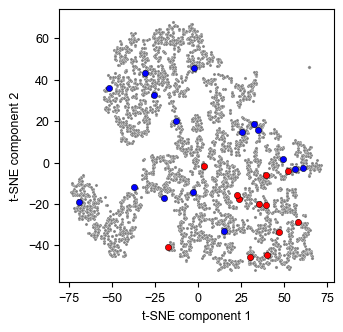

,id_num,layers,shells,metrics,col_list,num_features,rep,seed,perp
2764,2764,[inner],[membrane],"[charge, hydrophobicity, depth_6, prob]","[inner-membrane-charge-Mean, inner-membrane-hy...",4,1,8292,30


In [31]:
plt.rcParams['font.size'] = 9

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

current = membrane_id
part = labelled_tsne[labelled_tsne['id_num'] == current].copy()
temp = part[part['Protein name'] != 'other'].copy()
temp['label'] = temp['Protein name'].apply(lambda x: 'low' if x in low else 'high')

sns.scatterplot(data=part,x='x',y='y',color='grey',s=5)
sns.scatterplot(data=part[part['Protein name'].isin(low)],x='x',y='y',color='red',edgecolor='black',s=20)
sns.scatterplot(data=part[(~part['Protein name'].isin(low)) & (part['Protein name'] != 'other')],x='x',y='y',color='blue',edgecolor='black',s=20)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

plt.savefig(f'{fig_folder}/Supp_fig-sample_tSNE_membrane.svg',format='svg',dpi=300)

plt.show()
plt.rcParams['font.size'] = 7

export = part.copy()

def assign_label(name):
    if name == 'other':
        return 'not_tested'
    elif name in low:
        return 'low'
    else:
        return 'high'

export['tested'] = export['Protein name'].apply(assign_label)
export[['uniprot','Protein name','tested','x','y']].to_excel(f'{data_folder}/Supp_Fig_12A-Membrane_embedding.xlsx')

col_meta[col_meta['id_num'] == current]

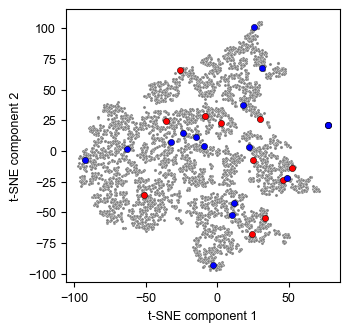

,id_num,layers,shells,metrics,col_list,num_features,rep,seed,perp
2795,2795,[water],[outside],"[charge, hydrophobicity, depth_6, prob]","[water-outside-charge-Mean, water-outside-hydr...",4,1,8385,30


In [32]:
plt.rcParams['font.size'] = 9

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

current = water_id
part = labelled_tsne[labelled_tsne['id_num'] == current].copy()
temp = part[part['Protein name'] != 'other'].copy()
temp['label'] = temp['Protein name'].apply(lambda x: 'low' if x in low else 'high')

sns.scatterplot(data=part,x='x',y='y',color='grey',s=5)
sns.scatterplot(data=part[part['Protein name'].isin(low)],x='x',y='y',color='red',edgecolor='black',s=20)
sns.scatterplot(data=part[(~part['Protein name'].isin(low)) & (part['Protein name'] != 'other')],x='x',y='y',color='blue',edgecolor='black',s=20)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# plt.savefig(f'{fig_folder}/Supp_fig-sample_tSNE_water.svg',format='svg',dpi=300)
plt.show()

plt.rcParams['font.size'] = 7
export = part.copy()

def assign_label(name):
    if name == 'other':
        return 'not_tested'
    elif name in low:
        return 'low'
    else:
        return 'high'

export['tested'] = export['Protein name'].apply(assign_label)
export[['uniprot','Protein name','tested','x','y']].to_excel(f'{data_folder}/Supp_Fig_12B-Water_embedding.xlsx')

col_meta[col_meta['id_num'] == current]

# Evaluate the embeddings based on how well grouped the classes are

### Train a classifier for each protein feature embedding
* Each embedding is scored based on the accuracy of the classifiers that are trained using the locations of the two classes in the embedded space
* To evaluate the performance of the classifier on all proteins, an ensemble of classifiers are trained on different splits of the data
* Models only predict on the proteins that were excluded from their training data
* Given the small number of proteins, the spliting of the data into folds is replicated with different random seeds to best approximate how the model would actually perform
* It is important to note that a different standard scaler needs to be fit to each embedding

In [28]:
folds = range(5)

def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]

all_predictions = []

for id_num,embed_df in labelled_tsne.groupby('id_num'):
    print(id_num)
    part = embed_df[['Protein name','x','y']]
    part = part[part['Protein name'] != 'other'].copy()
    part['label'] = part['Protein name'].apply(lambda x: 0 if x in low else 1)
    part = part.reset_index(drop=True).reset_index().rename(columns={'index':'prot_id'})
    
    all_folds = []
    replicates = 10
    for i in range(replicates):
        test_ids = partition(part['prot_id'].tolist(),len(folds),random_seed=i)
        fold_df = pd.DataFrame(test_ids,columns=['fold','test_ids'])
        fold_df['train_ids'] = fold_df['test_ids'].apply(get_train_ids,available_ids=part['prot_id'].tolist())
        fold_df['rep'] = i
        all_folds.append(fold_df)

    all_folds = pd.concat(all_folds).reset_index(drop=True)
    
    cols = ['x','y']
    all_scaled = np.array(embed_df[cols])
    scaled = np.array(part[cols])

    scaler = StandardScaler()
    scaler = scaler.fit(all_scaled)
    scaled = scaler.transform(scaled)
    part[['x_scaled','y_scaled']] = scaled
    
    predictions = []
    for i,row in all_folds.iterrows():
        train_df = part[part['prot_id'].isin(row['train_ids'])]
        X_train = np.array(train_df[['x','y']])
        y_train = np.array(train_df['label'])  

        clf = SVC(random_state=row['rep'],C=100,probability=True)

        clf.fit(X_train, y_train)

        test_df = part[part['prot_id'].isin(row['test_ids'])].copy()
        X_test = np.array(test_df[['x','y']])
        preds = clf.predict(X_test)
        test_df['pred'] = preds
        lr_probs = clf.predict_proba(X_test)[:, 1]
        test_df['proba'] = lr_probs
        predictions.append(test_df)
    predictions = pd.concat(predictions).reset_index(drop=True)
    predictions['id_num'] = id_num
    
    all_predictions.append(predictions)

all_predictions = pd.concat(all_predictions)
all_predictions

0
1
2
3
4
5
6
7
9
12
16
22
23
24
25
26
27
28
29
31
34
38
44
52
53
54
55
56
57
58
60
61
63
66
67
69
72
76
82
84
86
87
89
90
91
92
93
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
111
113
114
116
117
118
119
120
122
123
124
125
126
127
128
129
130
131
132
133
134
135
138
141
143
144
146
147
148
149
150
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
175
178
182
188
189
190
191
192
193
194
195
197
200
204
210
218
219
220
221
222
223
224
226
227
229
232
233
235
238
242
248
250
252
253
255
256
257
258
259
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
277
279
280
282
283
284
285
286
288
289
290
291
292
293
294
295
296
297
298
299
300
301
304
307
309
310
312
313
314
315
316
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
341
344
348
354
355
356
357
358
359
360
361
363
366
370
376
384
385
386
387
388
389
390
392
393
395
398
399
401
404
408
414
416
418
419
421
422
423
424
425
427
428
429
430
4

,prot_id,Protein name,x,y,label,x_scaled,y_scaled,pred,proba,id_num
0,0,Aux,0.178,-3.163,1,-0.015,-0.125,1,0.526,0
1,3,CD63,-32.285,10.332,0,-0.939,0.283,0,0.627,0
2,6,B3AR,-49.696,-10.835,0,-1.434,-0.358,0,0.728,0
3,15,Vol,30.172,32.284,1,0.838,0.948,0,0.661,0
4,23,OR2AG1,2.049,67.554,0,0.038,2.017,0,0.675,0
...,...,...,...,...,...,...,...,...,...,...
275,8,CD9,9.562,-23.627,1,0.321,-0.866,0,0.447,2940
276,10,OR1D2,11.081,-8.483,0,0.374,-0.351,0,0.567,2940
277,18,CaM,-4.146,22.759,1,-0.152,0.710,1,0.583,2940
278,22,Neu,-11.903,61.762,0,-0.420,2.036,1,0.650,2940


In [29]:
all_predictions.to_pickle(data_folder+'/tSNE_classifier_predictions.pkl')

In [4]:
all_predictions = pd.read_pickle(data_folder+'/tSNE_classifier_predictions.pkl')

In [34]:
all_metrics = []

for id_num,pred_df in all_predictions.groupby('id_num'):
    accuracy = metrics.accuracy_score(pred_df['label'],pred_df['pred'])
    precision = metrics.precision_score(pred_df['label'],pred_df['pred'])
    recall = metrics.recall_score(pred_df['label'],pred_df['pred'])
    tn, fp, fn, tp = metrics.confusion_matrix(pred_df['label'],pred_df['pred']).ravel()
    all_metrics.append([id_num,accuracy,precision,recall,tn,fp,fn,tp])

all_metrics = pd.DataFrame(all_metrics,columns=['id_num','accuracy','precision','recall','tn','fp','fn','tp'])
all_metrics
    

,id_num,accuracy,precision,recall,tn,fp,fn,tp
0,0,0.454,0.522,0.512,45,75,78,82
1,1,0.489,0.552,0.569,46,74,69,91
2,2,0.586,0.633,0.656,59,61,55,105
3,3,0.279,0.350,0.306,29,91,111,49
4,4,0.386,0.458,0.412,42,78,94,66
...,...,...,...,...,...,...,...,...
1710,2936,0.579,0.628,0.644,59,61,57,103
1711,2937,0.629,0.684,0.650,72,48,56,104
1712,2938,0.686,0.714,0.750,72,48,40,120
1713,2939,0.514,0.594,0.475,68,52,84,76


### Fig 5B - Comparison of classifiers using different embeddings

In [35]:
label_metrics = all_metrics.set_index('id_num').join(col_meta.set_index('id_num')).reset_index()
label_metrics

,id_num,accuracy,precision,recall,tn,fp,fn,tp,layers,shells,metrics,col_list,num_features,rep,seed,perp
0,0,0.454,0.522,0.512,45,75,78,82,"[inner, outer]",[inside],[charge],"[inner-inside-charge-Mean, outer-inside-charge...",2,1,0,30
1,1,0.489,0.552,0.569,46,74,69,91,"[inner, polar]",[inside],[charge],"[inner-inside-charge-Mean, polar-inside-charge...",2,1,3,30
2,2,0.586,0.633,0.656,59,61,55,105,"[inner, interface]",[inside],[charge],"[inner-inside-charge-Mean, interface-inside-ch...",2,1,6,30
3,3,0.279,0.350,0.306,29,91,111,49,"[outer, polar]",[inside],[charge],"[outer-inside-charge-Mean, polar-inside-charge...",2,1,9,30
4,4,0.386,0.458,0.412,42,78,94,66,"[outer, interface]",[inside],[charge],"[outer-inside-charge-Mean, interface-inside-ch...",2,1,12,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2936,0.579,0.628,0.644,59,61,57,103,"[inner, outer, polar, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[inner-inside-charge-Mean, outer-inside-charge...",32,1,8808,30
1711,2937,0.629,0.684,0.650,72,48,56,104,"[inner, outer, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[inner-inside-charge-Mean, outer-inside-charge...",28,1,8811,30
1712,2938,0.686,0.714,0.750,72,48,40,120,"[inner, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[inner-inside-charge-Mean, polar-inside-charge...",32,1,8814,30
1713,2939,0.514,0.594,0.475,68,52,84,76,"[outer, polar, interface, water]","[inside, membrane, outside]","[charge, hydrophobicity, depth_6, prob]","[outer-inside-charge-Mean, polar-inside-charge...",32,1,8817,30


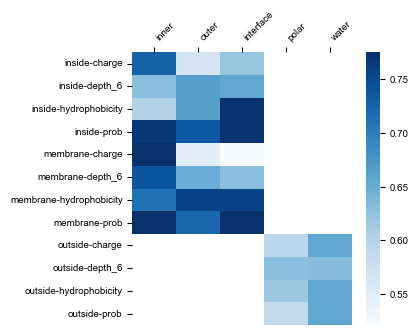

In [36]:
label_metrics = all_metrics.set_index('id_num').join(col_meta.set_index('id_num')).reset_index()
label_metrics = label_metrics[label_metrics['num_features'] <= 2]
label_metrics
label_metrics = label_metrics.explode('layers').explode('shells').explode('metrics')
label_metrics['name'] = label_metrics['shells'] + '-' + label_metrics['metrics']

label_metrics = label_metrics.groupby(['name','layers']).agg('max')[['accuracy']].unstack()
label_metrics.columns = label_metrics.columns.droplevel()
label_metrics = label_metrics[['inner','outer','interface','polar','water']]
label_metrics
label_metrics.loc[['inside-charge', 'inside-depth_6', 'inside-hydrophobicity',
       'inside-prob', 'membrane-charge', 'membrane-depth_6',
       'membrane-hydrophobicity', 'membrane-prob'],['polar','water']] = np.nan

label_metrics.loc[['outside-charge','outside-depth_6', 'outside-hydrophobicity', 'outside-prob'],['inner','outer','interface']] = np.nan

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

ax = sns.heatmap(label_metrics,cmap='Blues',ax=ax)
ax.xaxis.tick_top()
# ax.set(xticklabels=[])
# ax.set(yticklabels=[])
plt.xticks(rotation=45, ha='left')
plt.xlabel('')
plt.ylabel('')


# plt.savefig(f'{fig_folder}/Fig5B-init_classifiers_single.svg',format='svg',dpi=300)

plt.show()
# label_metrics.to_excel(f'{data_folder}/Fig5B-init_classifier_max.xlsx')

In [38]:
all_metrics.sort_values('accuracy',ascending=False).iloc[:20]

,id_num,accuracy,precision,recall,tn,fp,fn,tp
350,556,0.846,0.846,0.894,94,26,17,143
1389,2364,0.821,0.840,0.850,94,26,24,136
1393,2374,0.786,0.885,0.719,105,15,45,115
677,1108,0.775,0.821,0.775,93,27,36,124
334,522,0.775,0.794,0.819,86,34,29,131
1525,2626,0.771,0.812,0.781,91,29,35,125
899,1495,0.771,0.793,0.812,86,34,30,130
939,1590,0.768,0.810,0.775,91,29,36,124
323,500,0.768,0.806,0.781,90,30,35,125
820,1378,0.764,0.776,0.825,82,38,28,132


### Investigate the predictions of specific classifiers

layers     [inner, interface]
shells     [inside, membrane]
metrics                [prob]
Name: 11294788, dtype: object


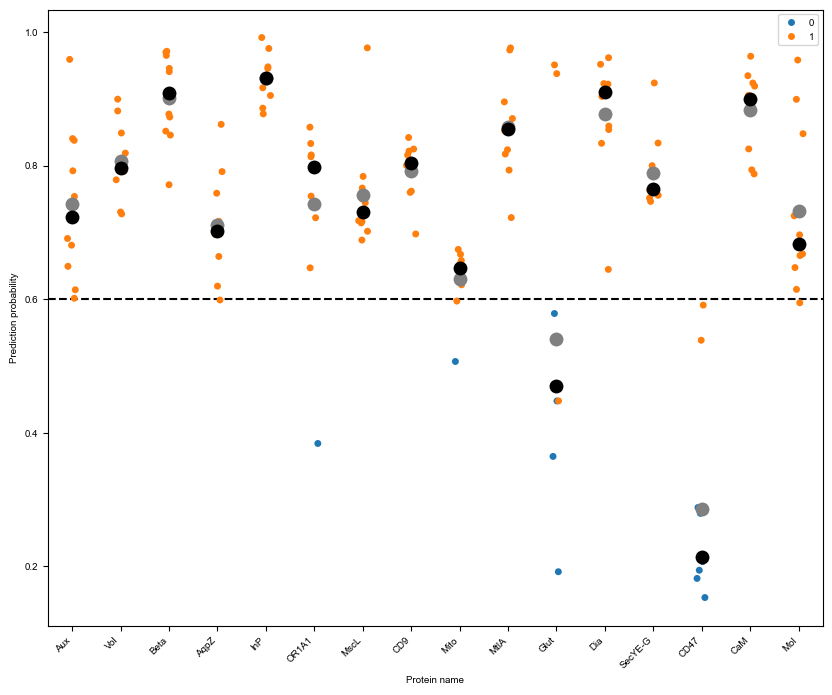

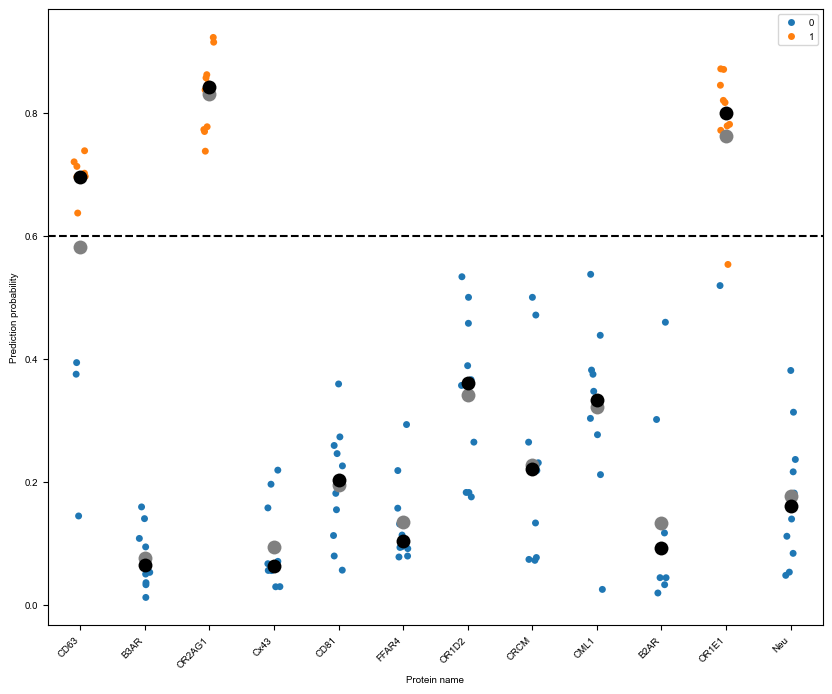

In [39]:
chosen_ids = [556]

preds = all_predictions[all_predictions['id_num'].isin(chosen_ids)]
print(labelled_tsne[labelled_tsne['id_num'] == chosen_ids[0]][['layers','shells','metrics']].iloc[0])


prot_order = preds[preds['label'] == 1]['Protein name'].unique()
sns.stripplot(data=preds[preds['label'] == 1],x='Protein name',y='proba',hue='pred',order=prot_order)
sns.stripplot(data=preds[preds['label'] == 1].groupby('Protein name').agg('mean').reset_index(),x='Protein name',y='proba',s=10,color='grey',order=prot_order)
sns.stripplot(data=preds[preds['label'] == 1].groupby('Protein name').agg('median').reset_index(),x='Protein name',y='proba',s=10,color='black',order=prot_order)

plt.xticks(rotation=45, ha='right')
plt.axhline(0.6,color='k',ls='--')
plt.ylabel('Prediction probability')
plt.show()

prot_order = preds[preds['label'] == 0]['Protein name'].unique()
sns.stripplot(data=preds[preds['label'] == 0],x='Protein name',y='proba',hue='pred',order=prot_order)
sns.stripplot(data=preds[preds['label'] == 0].groupby('Protein name').agg('mean').reset_index(),x='Protein name',y='proba',s=10,color='grey',order=prot_order)
sns.stripplot(data=preds[preds['label'] == 0].groupby('Protein name').agg('median').reset_index(),x='Protein name',y='proba',s=10,color='black',order=prot_order)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.6,color='k',ls='--')
plt.ylabel('Prediction probability')
plt.show()

['B2AR', 'B3AR', 'CD63', 'CD81', 'CML1', 'CRCM', 'Cx43', 'FFAR4', 'Neu', 'OR1D2', 'OR1E1', 'OR2AG1']


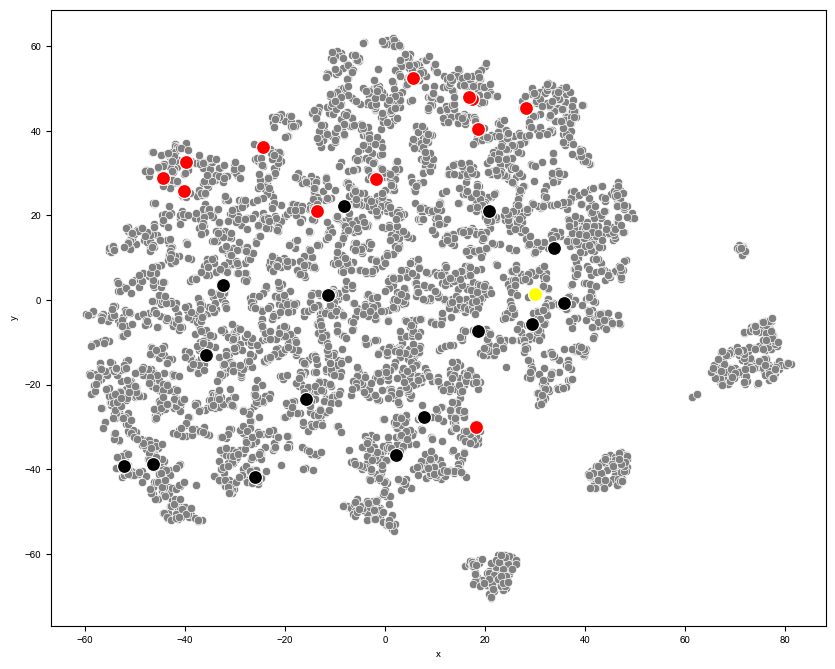

In [40]:
# [1300, 1579]
# current = 2364
current = 556
part = labelled_tsne[labelled_tsne['id_num'] == current].copy()
temp = part[part['Protein name'] != 'other'].copy()
temp['label'] = temp['Protein name'].apply(lambda x: 'low' if x in low else 'high')
print(low)
sns.scatterplot(data=part,x='x',y='y',color='grey')
sns.scatterplot(data=part[part['Protein name'] != 'other'],x='x',y='y',color='black',s=100)
sns.scatterplot(data=part[part['Protein name'].isin(low)],x='x',y='y',color='red',s=100)
highlight = [
    # 'OR1A1',
    # 'B2AR',
    'CD9',
    # 'Glut'
]
# highlight = ['MscL']

sns.scatterplot(data=part[part['Protein name'].isin(highlight)],x='x',y='y',color='yellow',s=100,alpha=1)

plt.show()

## Supp Fig 13 - Evaluating the combination of top embeddings into single classifiers
* Took all the single embedding classifiers that performed above the set threshold and paired the embeddings together
* Each new paired set of embeddings were used to train a new ensemble of classifiers
* The length of the protein was also included as a feature to further improve the separation of the classes

In [41]:
temp_metrics = all_metrics.set_index('id_num').join(col_meta[['id_num','rep']].set_index('id_num')).reset_index()
temp_metrics = temp_metrics[temp_metrics['rep'] == 1]
temp_metrics = temp_metrics[temp_metrics['accuracy'] > 0.75]
top_ids = temp_metrics['id_num'].tolist()
print(len(top_ids))

17


In [42]:
id_pairs = [list(i) for i in itertools.combinations(top_ids,2)]
print(len(id_pairs))

136


In [44]:
folds = range(5)

def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]

paired_predictions = []
all_clfs = []
# all_scalers = {}

for pair_id,pair in enumerate(id_pairs):
    print(pair_id,pair)
    
    temp_tsne = labelled_tsne[['id_num','uniprot','Protein name','x','y']]
    temp_tsne = temp_tsne[temp_tsne['id_num'].isin(pair)] 

    all_comb = []
    for id_num, id_df in temp_tsne.groupby('id_num'):
        temp = id_df.copy()
        temp = temp.drop(columns=['id_num']).set_index(['uniprot','Protein name'])
        temp = temp.rename(columns={'x':f'x_{id_num}','y':f'y_{id_num}'})
        all_comb.append(temp)
    all_comb = pd.concat(all_comb,axis=1).reset_index()
    all_comb = all_comb.set_index('uniprot').join(anno_df[['Uniprot','Length']].set_index('Uniprot')).reset_index()
    
    part = all_comb[all_comb['Protein name'] != 'other'].copy()
    # low_sub = ['B3AR','CML1','CRCM','FFAR4','Neu','OR1D2','OR1E1','OR2AG1','Vol']
    part['label'] = part['Protein name'].apply(lambda x: 0 if x in low else 1)
    part = part.reset_index(drop=True).reset_index().rename(columns={'index':'prot_id'})

    all_folds = []
    replicates = 10
    for i in range(replicates):
        test_ids = partition(part['prot_id'].tolist(),len(folds),random_seed=i)
        fold_df = pd.DataFrame(test_ids,columns=['fold','test_ids'])
        fold_df['train_ids'] = fold_df['test_ids'].apply(get_train_ids,available_ids=part['prot_id'].tolist())
        fold_df['rep'] = i
        all_folds.append(fold_df)

    all_folds = pd.concat(all_folds).reset_index(drop=True)

    cols = all_comb.set_index(['uniprot','Protein name']).columns.tolist()

    all_scaled = np.array(all_comb[cols])
    scaled = np.array(part[cols])

    scaler = StandardScaler()
    scaler = scaler.fit(all_scaled)
    scaled = scaler.transform(scaled)
    part[cols] = scaled

    predictions = []
    pair_clfs = []
    for i,row in all_folds.iterrows():
        train_df = part[part['prot_id'].isin(row['train_ids'])]
        X_train = np.array(train_df[cols])
        y_train = np.array(train_df['label'])  

        clf = SVC(random_state=row['rep'],C=100,probability=True)

        clf.fit(X_train, y_train)
        pair_clfs.append(clf)

        test_df = part[part['prot_id'].isin(row['test_ids'])].copy()
        X_test = np.array(test_df[cols])
        preds = clf.predict(X_test)
        test_df['pred'] = preds
        lr_probs = clf.predict_proba(X_test)[:, 1]
        test_df['proba'] = lr_probs
        predictions.append(test_df)
    predictions = pd.concat(predictions).reset_index(drop=True)
    predictions['pair_id'] = pair_id
    predictions['pair'] = [pair for p in range(len(predictions))]
    
    paired_predictions.append(predictions)
    all_clfs.append([pair_id,pair_clfs])

paired_predictions = pd.concat(paired_predictions)
paired_predictions

0 [192, 233]
1 [192, 500]
2 [192, 507]
3 [192, 521]
4 [192, 522]
5 [192, 556]
6 [192, 641]
7 [192, 1108]
8 [192, 1378]
9 [192, 1495]
10 [192, 1590]
11 [192, 1892]
12 [192, 2350]
13 [192, 2364]
14 [192, 2374]
15 [192, 2626]
16 [233, 500]
17 [233, 507]
18 [233, 521]
19 [233, 522]
20 [233, 556]
21 [233, 641]
22 [233, 1108]
23 [233, 1378]
24 [233, 1495]
25 [233, 1590]
26 [233, 1892]
27 [233, 2350]
28 [233, 2364]
29 [233, 2374]
30 [233, 2626]
31 [500, 507]
32 [500, 521]
33 [500, 522]
34 [500, 556]
35 [500, 641]
36 [500, 1108]
37 [500, 1378]
38 [500, 1495]
39 [500, 1590]
40 [500, 1892]
41 [500, 2350]
42 [500, 2364]
43 [500, 2374]
44 [500, 2626]
45 [507, 521]
46 [507, 522]
47 [507, 556]
48 [507, 641]
49 [507, 1108]
50 [507, 1378]
51 [507, 1495]
52 [507, 1590]
53 [507, 1892]
54 [507, 2350]
55 [507, 2364]
56 [507, 2374]
57 [507, 2626]
58 [521, 522]
59 [521, 556]
60 [521, 641]
61 [521, 1108]
62 [521, 1378]
63 [521, 1495]
64 [521, 1590]
65 [521, 1892]
66 [521, 2350]
67 [521, 2364]
68 [521, 2374]


,prot_id,uniprot,Protein name,x_192,y_192,x_233,y_233,Length,label,pred,...,x_1892,y_1892,x_2350,y_2350,x_2364,y_2364,x_2374,y_2374,x_2626,y_2626
0,0,F4HWB6,Aux,0.231,1.697,0.068,0.956,0.071,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,P08962,CD63,-0.442,-0.933,-0.560,-0.181,-0.862,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,P13945,B3AR,-0.911,0.004,-0.553,0.321,-0.185,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15,Q5JW98,Vol,0.765,0.315,-1.492,-0.867,-0.559,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,Q9H205,OR2AG1,0.436,0.850,0.073,-0.565,-0.551,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,8,P21926,CD9,NaN,NaN,NaN,NaN,-0.902,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.226,0.847,0.529,1.416
276,10,P34982,OR1D2,NaN,NaN,NaN,NaN,-0.567,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.119,0.654,-0.111,1.956
277,18,Q8IU99,CaM,NaN,NaN,NaN,NaN,-0.432,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1.036,1.108,0.993,0.350
278,22,Q9BWQ8,Neu,NaN,NaN,NaN,NaN,-0.551,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.163,1.571,0.347,1.433


In [43]:
# paired_predictions.to_pickle(data_folder+'/tSNE_paired_predictions.pkl')
paired_predictions = pd.read_pickle(data_folder+'/tSNE_paired_predictions.pkl')

In [44]:
paired_metrics = []

for pair_id,pred_df in paired_predictions.groupby('pair_id'):
    accuracy = metrics.accuracy_score(pred_df['label'],pred_df['pred'])
    precision = metrics.precision_score(pred_df['label'],pred_df['pred'])
    recall = metrics.recall_score(pred_df['label'],pred_df['pred'])
    tn, fp, fn, tp = metrics.confusion_matrix(pred_df['label'],pred_df['pred']).ravel()
    paired_metrics.append([pair_id,accuracy,precision,recall,tn,fp,fn,tp])

paired_metrics = pd.DataFrame(paired_metrics,columns=['pair_id','accuracy','precision','recall','tn','fp','fn','tp'])
paired_metrics.sort_values('accuracy',ascending=False)

,pair_id,accuracy,precision,recall,tn,fp,fn,tp
104,104,0.882,0.894,0.900,103,17,16,144
101,101,0.857,0.853,0.906,95,25,15,145
100,100,0.854,0.836,0.925,91,29,12,148
46,46,0.850,0.878,0.856,101,19,23,137
20,20,0.850,0.843,0.906,93,27,15,145
...,...,...,...,...,...,...,...,...
121,121,0.550,0.609,0.594,59,61,65,95
109,109,0.546,0.608,0.581,60,60,67,93
123,123,0.525,0.592,0.544,60,60,73,87
124,124,0.511,0.576,0.544,56,64,73,87


In [45]:
paired_metrics.sort_values('accuracy',ascending=False).head(20)

,pair_id,accuracy,precision,recall,tn,fp,fn,tp
104,104,0.882,0.894,0.900,103,17,16,144
101,101,0.857,0.853,0.906,95,25,15,145
100,100,0.854,0.836,0.925,91,29,12,148
46,46,0.850,0.878,0.856,101,19,23,137
20,20,0.850,0.843,0.906,93,27,15,145
89,89,0.846,0.893,0.831,104,16,27,133
31,31,0.839,0.853,0.869,96,24,21,139
47,47,0.839,0.836,0.894,92,28,17,143
64,64,0.836,0.839,0.881,93,27,19,141
49,49,0.836,0.848,0.869,95,25,21,139


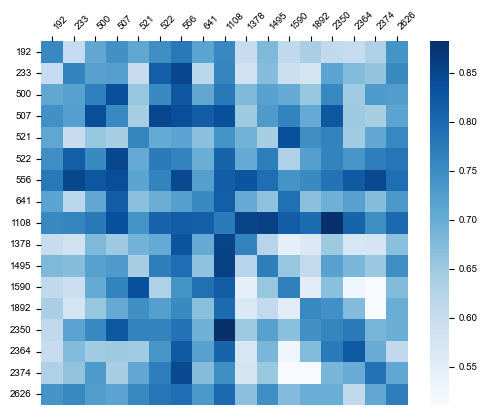

In [46]:
pair_lookup = paired_predictions[['pair_id','pair']].drop_duplicates(subset=['pair_id'])

heat = paired_metrics.set_index('pair_id').join(pair_lookup.set_index('pair_id')).reset_index()
top = heat.copy()
top['first'] = top['pair'].apply(lambda x: x[0])
top['second'] = top['pair'].apply(lambda x: x[1])
top
bottom = heat.copy()
bottom['first'] = bottom['pair'].apply(lambda x: x[1])
bottom['second'] = bottom['pair'].apply(lambda x: x[0])

heat = pd.concat([top,bottom]).reset_index(drop=True)[['first','second','accuracy']]
single = all_metrics[['id_num','accuracy']]
single = single[single['id_num'].isin(heat['first'].unique().tolist())]
single = single.rename(columns={'id_num':'first'})
single['second'] = single['first']
heat = pd.concat([heat,single]).reset_index(drop=True)

heat = heat.set_index(['first','second']).unstack()

heat.columns = heat.index
fig,ax = plt.subplots(figsize=[15*cm,12*cm])

ax = sns.heatmap(heat,cmap='Blues',ax=ax)
ax.xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.xlabel('')
plt.ylabel('')

# plt.savefig(f'{fig_folder}/supp_fig-pair_comparison.svg',format='svg',dpi=300)

plt.show()

# heat.to_excel(f'{data_folder}/Supp_Fig-pair_comparison.xlsx')

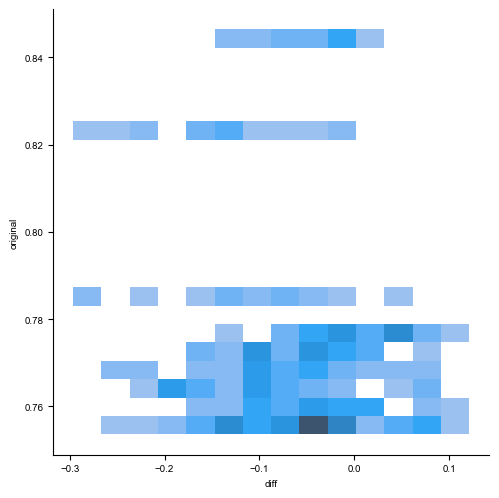

In [47]:
pair_lookup = paired_predictions[['pair_id','pair']].drop_duplicates(subset=['pair_id'])

heat = paired_metrics.set_index('pair_id').join(pair_lookup.set_index('pair_id')).reset_index()
top = heat.copy()
top['first'] = top['pair'].apply(lambda x: x[0])
top['second'] = top['pair'].apply(lambda x: x[1])
top
bottom = heat.copy()
bottom['first'] = bottom['pair'].apply(lambda x: x[1])
bottom['second'] = bottom['pair'].apply(lambda x: x[0])

heat = pd.concat([top,bottom]).reset_index(drop=True)[['first','second','accuracy']]
single = all_metrics[['id_num','accuracy']]
single = single[single['id_num'].isin(heat['first'].unique().tolist())]
single = single.rename(columns={'id_num':'first','accuracy':'original'})
heat = heat.set_index('first').join(single.set_index('first')).reset_index()
heat['diff'] = heat['accuracy'] - heat['original'] 
# sns.scatterplot(data=heat,x='original',y='diff')
sns.displot(data=heat,x='diff',y='original')
# plt.axvline(0,color='k',ls='--')
plt.show()

10


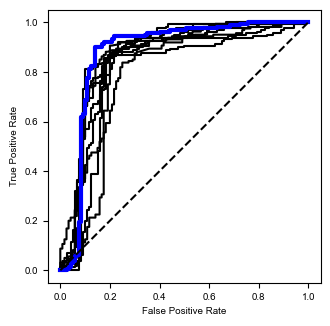

In [48]:
chosen = paired_metrics.sort_values('accuracy',ascending=False)
chosen = chosen[chosen['accuracy'] > 0.83]['pair_id'].tolist()
print(len(chosen))
temp_preds = paired_predictions[paired_predictions['pair_id'].isin(chosen)]
fig,ax = plt.subplots(figsize=[9*cm,9*cm])

all_roc_scores = []

for pair_id,pair_df in temp_preds.groupby('pair_id'):
    fpr, tpr, thresholds = roc_curve(pair_df['label'],pair_df['proba'])
    ax.plot(fpr,tpr,color='k',label=str(pair_id))
    roc_scores = pd.DataFrame(np.array(list(zip(fpr,tpr))),columns=['fpr','tpr'])
    roc_scores['pair_id'] = pair_id
    all_roc_scores.append(roc_scores)
    
temp_preds = paired_predictions[paired_predictions['pair_id'] == chosen[0]]
fpr, tpr, thresholds = roc_curve(temp_preds['label'],temp_preds['proba'])


ax.plot(fpr,tpr,color='blue',lw=3,label=chosen[0])

plt.axis("square")
plt.plot([0,1],[0,1],color='k',ls='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# plt.savefig(f'{fig_folder}/Supp_Fig_13-above83_ROC.svg',format='svg',dpi=300)
plt.show()

all_roc_scores = pd.concat(all_roc_scores)
# all_roc_scores.to_excel(f'{data_folder}/Supp_Fig_13-ROC_above83.xlsx')


## Fig 5C - Predictions on each protein by the most accurate model

In [104]:
paired_metrics.sort_values('accuracy',ascending=False).head(20)

,pair_id,accuracy,precision,recall,tn,fp,fn,tp
104,104,0.882,0.894,0.900,103,17,16,144
101,101,0.857,0.853,0.906,95,25,15,145
100,100,0.854,0.836,0.925,91,29,12,148
46,46,0.850,0.878,0.856,101,19,23,137
20,20,0.850,0.843,0.906,93,27,15,145
89,89,0.846,0.893,0.831,104,16,27,133
31,31,0.839,0.853,0.869,96,24,21,139
47,47,0.839,0.836,0.894,92,28,17,143
64,64,0.836,0.839,0.881,93,27,19,141
49,49,0.836,0.848,0.869,95,25,21,139


In [49]:
chosen_ids = paired_predictions[paired_predictions['pair_id'] == 104].iloc[0]['pair'] # Most accurate
# chosen_ids = paired_predictions[paired_predictions['pair_id'] == 81].iloc[0]['pair'] # Second most accurate
# chosen_ids = paired_predictions[paired_predictions['pair_id'] == 74].iloc[0]['pair'] # Second most accurate

chosen_ids

[1108, 2350]

In [50]:
include_ids = labelled_tsne[labelled_tsne['id_num'].isin(chosen_ids)]['id_num'].tolist()

temp_tsne = labelled_tsne[['id_num','uniprot','Protein name','x','y']]
temp_tsne = temp_tsne[temp_tsne['id_num'].isin(include_ids)] 

all_comb = []
for id_num, id_df in temp_tsne.groupby('id_num'):
    temp = id_df.copy()
    temp = temp.drop(columns=['id_num']).set_index(['uniprot','Protein name'])
    temp = temp.rename(columns={'x':f'x_{id_num}','y':f'y_{id_num}'})
    all_comb.append(temp)
all_comb = pd.concat(all_comb,axis=1).reset_index()
all_comb = all_comb.set_index('uniprot').join(anno_df[['Uniprot','Length']].set_index('Uniprot')).reset_index()
all_comb

,uniprot,Protein name,x_1108,y_1108,x_2350,y_2350,Length
0,A0A075B734,other,56.754,-6.854,-2.985,67.189,347
1,A0A087WTH1,other,52.310,18.769,32.760,29.673,108
2,A0A096LPK9,other,-26.158,-71.702,58.999,-27.197,316
3,A0A0X1KG70,other,54.646,-22.702,-17.455,61.262,313
4,A0A1B0GTI8,other,51.553,-28.250,-16.144,54.629,187
...,...,...,...,...,...,...,...
4607,Q9ZWB9,other,2.578,55.243,9.870,37.897,758
4608,Q9ZWD1,other,56.784,-22.068,-14.215,61.583,187
4609,Q9ZWG1,other,-35.874,-88.372,85.116,19.882,305
4610,Q9ZWI7,other,50.083,45.525,26.123,33.456,212


In [51]:
col_meta[col_meta['id_num'].isin(chosen_ids)]

,id_num,layers,shells,metrics,col_list,num_features,rep,seed,perp
1108,1108,[inner],[membrane],"[charge, prob]","[inner-membrane-charge-Mean, inner-membrane-pr...",2,1,3324,30
2350,2350,[inner],[membrane],"[charge, depth_6, prob]","[inner-membrane-charge-Mean, inner-membrane-de...",3,1,7050,30


In [52]:
folds = range(5)

def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]


# part = embed_df[['Protein name','x','y']]
part = all_comb[all_comb['Protein name'] != 'other'].copy()
# low_sub = ['B3AR','CML1','CRCM','FFAR4','Neu','OR1D2','OR1E1','OR2AG1','Vol']
part['label'] = part['Protein name'].apply(lambda x: 0 if x in low else 1)
part = part.reset_index(drop=True).reset_index().rename(columns={'index':'prot_id'})

all_folds = []
replicates = 10
for i in range(replicates):
    test_ids = partition(part['prot_id'].tolist(),len(folds),random_seed=i)
    fold_df = pd.DataFrame(test_ids,columns=['fold','test_ids'])
    fold_df['train_ids'] = fold_df['test_ids'].apply(get_train_ids,available_ids=part['prot_id'].tolist())
    fold_df['rep'] = i
    all_folds.append(fold_df)

all_folds = pd.concat(all_folds).reset_index(drop=True)

cols = all_comb.set_index(['uniprot','Protein name']).columns.tolist()

all_scaled = np.array(all_comb[cols])
scaled = np.array(part[cols])

scaler = StandardScaler()
scaler = scaler.fit(all_scaled)
scaled = scaler.transform(scaled)
part[cols] = scaled

predictions = []
current_clfs = []
for i,row in all_folds.iterrows():
    train_df = part[part['prot_id'].isin(row['train_ids'])]
    X_train = np.array(train_df[cols])
    y_train = np.array(train_df['label'])  

    clf = SVC(random_state=row['rep'],C=100,probability=True)

    clf.fit(X_train, y_train)
    current_clfs.append(clf)

    test_df = part[part['prot_id'].isin(row['test_ids'])].copy()
    X_test = np.array(test_df[cols])
    preds = clf.predict(X_test)
    test_df['pred'] = preds
    lr_probs = clf.predict_proba(X_test)[:, 1]
    test_df['proba'] = lr_probs
    predictions.append(test_df)
predictions = pd.concat(predictions).reset_index(drop=True)
predictions

,prot_id,uniprot,Protein name,x_1108,y_1108,x_2350,y_2350,Length,label,pred,proba
0,0,F4HWB6,Aux,0.672,-0.707,-0.947,0.986,0.071,1,1,0.930
1,3,P08962,CD63,-1.296,0.062,1.416,0.408,-0.862,0,0,0.333
2,6,P13945,B3AR,-0.579,-1.265,1.014,-1.193,-0.185,0,0,0.124
3,15,Q5JW98,Vol,-1.287,0.717,1.332,0.638,-0.559,1,1,0.893
4,23,Q9H205,OR2AG1,0.334,1.339,-0.409,0.278,-0.551,0,1,0.967
...,...,...,...,...,...,...,...,...,...,...,...
275,8,P21926,CD9,0.607,0.792,1.042,0.578,-0.902,1,1,0.882
276,10,P34982,OR1D2,-0.754,-0.692,0.718,-0.775,-0.567,0,0,0.277
277,18,Q8IU99,CaM,0.457,0.288,1.103,0.533,-0.432,1,1,0.911
278,22,Q9BWQ8,Neu,-1.874,-0.703,1.590,-0.132,-0.551,0,0,0.083


In [53]:
accuracy = metrics.accuracy_score(predictions['label'],predictions['pred'])
precision = metrics.precision_score(predictions['label'],predictions['pred'])
recall = metrics.recall_score(predictions['label'],predictions['pred'])
tn, fp, fn, tp = metrics.confusion_matrix(predictions['label'],predictions['pred']).ravel()
print(accuracy)

0.8821428571428571


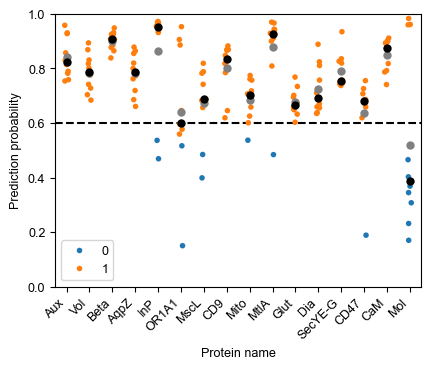

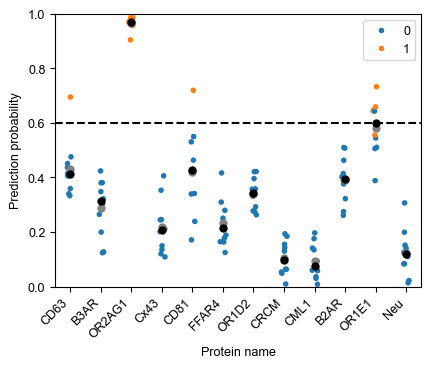

In [55]:
preds = predictions[['Protein name','label','proba','pred']]

size = 6

plt.rcParams['font.size'] = 9

fig,ax = plt.subplots(figsize=[12*cm,9*cm])

prot_order = preds[preds['label'] == 1]['Protein name'].unique()
sns.stripplot(data=preds[preds['label'] == 1],x='Protein name',y='proba',hue='pred',order=prot_order,s=size-2)
sns.stripplot(data=preds[preds['label'] == 1].groupby('Protein name').agg('mean').reset_index(),x='Protein name',y='proba',s=size,color='grey',order=prot_order)
sns.stripplot(data=preds[preds['label'] == 1].groupby('Protein name').agg('median').reset_index(),x='Protein name',y='proba',s=size,color='black',order=prot_order)

plt.xticks(rotation=45, ha='right')
plt.axhline(0.6,color='k',ls='--')
plt.ylabel('Prediction probability')
plt.ylim([0,1])
# plt.savefig(f'{fig_folder}/Supp_fig-mid_preds_1.svg',format='svg',dpi=300)
plt.show()

fig,ax = plt.subplots(figsize=[12*cm,9*cm])

prot_order = preds[preds['label'] == 0]['Protein name'].unique()
sns.stripplot(data=preds[preds['label'] == 0],x='Protein name',y='proba',hue='pred',order=prot_order,s=size-2)
sns.stripplot(data=preds[preds['label'] == 0].groupby('Protein name').agg('mean').reset_index(),x='Protein name',y='proba',s=size,color='grey',order=prot_order)
sns.stripplot(data=preds[preds['label'] == 0].groupby('Protein name').agg('median').reset_index(),x='Protein name',y='proba',s=size,color='black',order=prot_order)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.6,color='k',ls='--')
plt.ylabel('Prediction probability')
plt.ylim([0,1])
# plt.savefig(f'{fig_folder}/Supp_fig-mid_preds_0.svg',format='svg',dpi=300)
plt.show()

preds.to_excel(f'{data_folder}/Supp_fig-most_accurate_predictions.xlsx')

plt.rcParams['font.size'] = 7


In [56]:
all_scaled = scaler.transform(np.array(all_comb[cols]))

comp_preds = []
for clf in current_clfs:
    pred_df = all_comb.copy()
    preds = clf.predict(all_scaled)
    pred_df['pred'] = preds
    lr_probs = clf.predict_proba(all_scaled)[:, 1]
    pred_df['proba'] = lr_probs
    comp_preds.append(pred_df)
    
comp_preds = pd.concat(comp_preds)
comp_preds

,uniprot,Protein name,x_1108,y_1108,x_2350,y_2350,Length,pred,proba
0,A0A075B734,other,56.754,-6.854,-2.985,67.189,347,1,0.895
1,A0A087WTH1,other,52.310,18.769,32.760,29.673,108,1,0.952
2,A0A096LPK9,other,-26.158,-71.702,58.999,-27.197,316,0,0.061
3,A0A0X1KG70,other,54.646,-22.702,-17.455,61.262,313,1,0.892
4,A0A1B0GTI8,other,51.553,-28.250,-16.144,54.629,187,1,0.901
...,...,...,...,...,...,...,...,...,...
4607,Q9ZWB9,other,2.578,55.243,9.870,37.897,758,1,0.970
4608,Q9ZWD1,other,56.784,-22.068,-14.215,61.583,187,1,0.825
4609,Q9ZWG1,other,-35.874,-88.372,85.116,19.882,305,0,0.308
4610,Q9ZWI7,other,50.083,45.525,26.123,33.456,212,1,0.797


In [57]:
comp_preds = comp_preds.groupby(['uniprot','Protein name']).agg('mean').reset_index()
comp_preds

,uniprot,Protein name,x_1108,y_1108,x_2350,y_2350,Length,pred,proba
0,A0A075B734,other,56.754,-6.854,-2.985,67.189,347.000,1.000,0.818
1,A0A087WTH1,other,52.310,18.769,32.760,29.673,108.000,1.000,0.851
2,A0A096LPK9,other,-26.158,-71.702,58.999,-27.197,316.000,0.000,0.161
3,A0A0X1KG70,other,54.646,-22.702,-17.455,61.262,313.000,1.000,0.815
4,A0A1B0GTI8,other,51.553,-28.250,-16.144,54.629,187.000,1.000,0.814
...,...,...,...,...,...,...,...,...,...
4607,Q9ZWB9,other,2.578,55.243,9.870,37.897,758.000,1.000,0.905
4608,Q9ZWD1,other,56.784,-22.068,-14.215,61.583,187.000,1.000,0.808
4609,Q9ZWG1,other,-35.874,-88.372,85.116,19.882,305.000,0.020,0.394
4610,Q9ZWI7,other,50.083,45.525,26.123,33.456,212.000,0.960,0.774


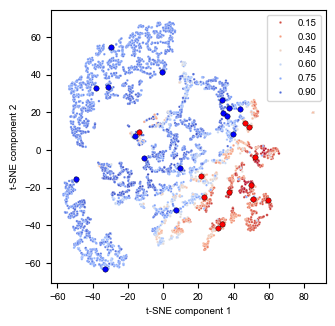

In [58]:
temp = comp_preds[comp_preds['Protein name'] != 'other'].copy()
temp['label'] = temp['Protein name'].apply(lambda x: 0 if x in low else 1)

x_axis = 'x_2350'
y_axis = 'y_2350'

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

sns.scatterplot(data=comp_preds,x=x_axis,y=y_axis,hue='proba',s=3,palette='coolwarm_r')
sns.scatterplot(data=temp[temp['label'] == 0],x=x_axis,y=y_axis,color='red',edgecolor='black',s=15)
sns.scatterplot(data=temp[temp['label'] == 1],x=x_axis,y=y_axis,color='blue',edgecolor='black',s=15)
# sns.scatterplot(data=temp[temp['Protein name'] == 'OR2AG1'],x=x_axis,y=y_axis,color='yellow',edgecolor='black',s=15)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# plt.savefig(f'{fig_folder}/Fig5C-preds_w_label_top.svg',format='svg',dpi=300)

plt.show()

other = comp_preds[comp_preds['Protein name'] == 'other']
export = pd.concat([temp,other])
# export.to_excel(f'{data_folder}/Fig5C-top_classifier_embedding.xlsx')

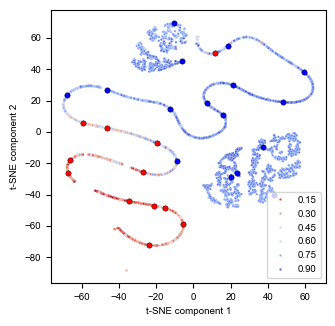

In [59]:
temp = comp_preds[comp_preds['Protein name'] != 'other'].copy()
temp['label'] = temp['Protein name'].apply(lambda x: 0 if x in low else 1)

x_axis = 'x_1108'
y_axis = 'y_1108'

fig,ax = plt.subplots(figsize=[9*cm,9*cm])



sns.scatterplot(data=comp_preds,x=x_axis,y=y_axis,hue='proba',s=3,palette='coolwarm_r')
sns.scatterplot(data=temp[temp['label'] == 0],x=x_axis,y=y_axis,color='red',edgecolor='black',s=15)
sns.scatterplot(data=temp[temp['label'] == 1],x=x_axis,y=y_axis,color='blue',edgecolor='black',s=15)
# sns.scatterplot(data=temp[temp['Protein name'] == 'OR2AG1'],x=x_axis,y=y_axis,color='yellow',edgecolor='black',s=15)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# plt.savefig(f'{fig_folder}/preds_w_label_top-coolwarm_single.svg',format='svg',dpi=300)

plt.show()

### Fig 5D - Use of the top performing classifiers to predict on all proteins in the dataset
* Set the threshold for inclusion in the final group of classifiers to 85% accuracy

In [60]:
chosen_pairs = paired_metrics[paired_metrics['accuracy'] > 0.83]['pair_id'].tolist()
print('Pairs being used:',len(chosen_pairs))

folds = range(5)

def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]


all_comp_preds = []
all_training_preds = []

for pair_id in chosen_pairs:
    print('Current ID:',pair_id)
    chosen_ids = paired_predictions[paired_predictions['pair_id'] == pair_id].iloc[0]['pair'] # Most accurate

    include_ids = labelled_tsne[labelled_tsne['id_num'].isin(chosen_ids)]['id_num'].tolist()

    temp_tsne = labelled_tsne[['id_num','uniprot','Protein name','x','y']]
    temp_tsne = temp_tsne[temp_tsne['id_num'].isin(include_ids)] 

    all_comb = []
    for id_num, id_df in temp_tsne.groupby('id_num'):
        temp = id_df.copy()
        temp = temp.drop(columns=['id_num']).set_index(['uniprot','Protein name'])
        temp = temp.rename(columns={'x':f'x_{id_num}','y':f'y_{id_num}'})
        all_comb.append(temp)
    all_comb = pd.concat(all_comb,axis=1).reset_index()
    all_comb = all_comb.set_index('uniprot').join(anno_df[['Uniprot','Length']].set_index('Uniprot')).reset_index()

    tested = all_comb[all_comb['Protein name'] != 'other'].copy()
    tested['label'] = tested['Protein name'].apply(lambda x: 0 if x in low else 1)
    tested = tested.reset_index(drop=True).reset_index().rename(columns={'index':'prot_id'})

    all_folds = []
    replicates = 10
    for i in range(replicates):
        test_ids = partition(tested['prot_id'].tolist(),len(folds),random_seed=i)
        fold_df = pd.DataFrame(test_ids,columns=['fold','test_ids'])
        fold_df['train_ids'] = fold_df['test_ids'].apply(get_train_ids,available_ids=tested['prot_id'].tolist())
        fold_df['rep'] = i
        all_folds.append(fold_df)

    all_folds = pd.concat(all_folds).reset_index(drop=True)

    cols = all_comb.set_index(['uniprot','Protein name']).columns.tolist()

    all_array = np.array(all_comb[cols])
    tested_array = np.array(tested[cols])

    scaler = StandardScaler()
    scaler = scaler.fit(all_array)
    tested_scaled = scaler.transform(tested_array)
    all_scaled = scaler.transform(all_array)

    tested[cols] = tested_scaled

    predictions = []
    current_clfs = []
    for i,row in all_folds.iterrows():
        train_df = tested[tested['prot_id'].isin(row['train_ids'])]
        X_train = np.array(train_df[cols])
        y_train = np.array(train_df['label'])  

        clf = SVC(random_state=row['rep'],C=100,probability=True)

        clf.fit(X_train, y_train)
        current_clfs.append(clf)

        test_df = tested[tested['prot_id'].isin(row['test_ids'])].copy()
        X_test = np.array(test_df[cols])
        preds = clf.predict(X_test)
        test_df['pred'] = preds
        lr_probs = clf.predict_proba(X_test)[:, 1]
        test_df['proba'] = lr_probs
        predictions.append(test_df)
    predictions = pd.concat(predictions).reset_index(drop=True)
    init_preds = predictions[['uniprot','Protein name','label','proba','pred']].copy()
    init_preds['pair_id'] = pair_id
    all_training_preds.append(init_preds)
    # all_scaled = scaler.transform(np.array(all_comb[cols]))
    all_array = np.array(all_comb[cols])
    all_scaled = scaler.transform(all_array)
    comp_preds = []
    for clf in current_clfs:
        pred_df = all_comb.copy()
        preds = clf.predict(all_scaled)
        pred_df['pred'] = preds
        lr_probs = clf.predict_proba(all_scaled)[:, 1]
        pred_df['proba'] = lr_probs
        comp_preds.append(pred_df)

    comp_preds = pd.concat(comp_preds)
    comp_preds['pair_id'] = pair_id
    
    # all_comp_preds.append(init_preds)
    all_comp_preds.append(comp_preds)
all_training_preds = pd.concat(all_training_preds)
all_comp_preds = pd.concat(all_comp_preds)
all_comp_preds

Pairs being used: 10
Current ID: 20
Current ID: 31
Current ID: 46
Current ID: 47
Current ID: 49
Current ID: 64
Current ID: 89
Current ID: 100
Current ID: 101
Current ID: 104


,uniprot,Protein name,x_233,y_233,x_556,y_556,Length,pred,proba,pair_id,...,x_1590,y_1590,x_2374,y_2374,x_1378,y_1378,x_1495,y_1495,x_2350,y_2350
0,A0A075B734,other,22.751,-46.385,-44.688,-45.168,347,1,0.882,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A087WTH1,other,29.924,-46.500,33.135,-17.662,108,1,0.929,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A0A096LPK9,other,-17.618,-44.309,3.520,56.633,316,0,0.031,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0X1KG70,other,1.391,-15.071,15.581,25.021,313,1,0.924,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0A1B0GTI8,other,-57.861,13.986,8.043,31.753,187,0,0.160,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,Q9ZWB9,other,NaN,NaN,NaN,NaN,758,1,0.970,104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.870,37.897
4608,Q9ZWD1,other,NaN,NaN,NaN,NaN,187,1,0.825,104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.215,61.583
4609,Q9ZWG1,other,NaN,NaN,NaN,NaN,305,0,0.308,104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.116,19.882
4610,Q9ZWI7,other,NaN,NaN,NaN,NaN,212,1,0.797,104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.123,33.456


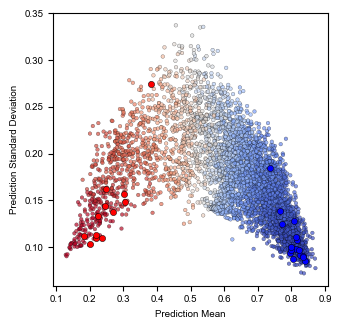

In [61]:
means = all_comp_preds[['uniprot','Protein name','pred','proba']].groupby(['uniprot','Protein name']).agg('mean')
stdevs = all_comp_preds[['uniprot','Protein name','pred','proba']].groupby(['uniprot','Protein name']).agg('std')
cvs = stdevs / means
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev').reset_index()
calcs


fig,ax = plt.subplots(figsize=[9*cm,9*cm])
sns.scatterplot(data=calcs,x='proba_mean',y='proba_stdev',hue='pred_mean',edgecolor='black',alpha=0.7,s=7,ax=ax,palette='coolwarm_r')

sns.scatterplot(data=calcs[(~calcs['Protein name'].isin(low)) & (calcs['Protein name'] != 'other')],x='proba_mean',y='proba_stdev',color='blue',edgecolor='black',alpha=1,s=20,ax=ax)
sns.scatterplot(data=calcs[calcs['Protein name'].isin(low)],x='proba_mean',y='proba_stdev',color='red',edgecolor='black',alpha=1,s=20,ax=ax)

ax.get_legend().remove()
plt.xlabel('Prediction Mean')
plt.ylabel('Prediction Standard Deviation')
# plt.savefig(f'{fig_folder}/Fig5D-mean_v_stdev_above_85_predictions.svg',format='svg',dpi=300)

plt.show()
# calcs.to_excel(f'{data_folder}/Fig5D-above85_accuracy_predictions.xlsx')

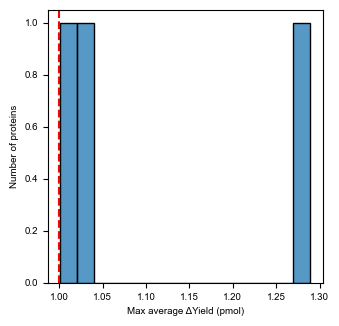

['Q8N6M3', 'Q8RXN3', 'Q96247']

In [62]:
new_prots = pd.read_pickle(data_folder+'/predicted_proteins_tested.pkl')
new_prots = new_prots[new_prots['DNA_name'] != 'AqpZ']
new_prots

rename_dict = {
    'FITM2':'Q8N6M3',
    'PPT1':'Q8RXN3',
    'AuxT1':'Q96247'
}

new_prots['uniprot'] = new_prots['DNA_name'].apply(lambda x: rename_dict[x])
new_prots

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

significance_threshold = 0.05
# difference_threshold = 20
difference_threshold = 1

temp = new_prots[new_prots['Liposome_name'] != 'no_lipo'].drop_duplicates(subset=['rxn_id'])
temp = temp[['DNA_name','mean_diff','p-val','score']]
temp = temp[temp['p-val'] < significance_threshold]
temp = temp.groupby('DNA_name')[['mean_diff']].agg('max').reset_index()
temp['mean_diff_clipped'] = temp['mean_diff'].clip(0,5)
sns.histplot(temp,x='mean_diff_clipped',ax=ax,bins=15)
plt.axvline(difference_threshold,c='r',ls='--',lw=1.5)
plt.xlabel('Max average ΔYield (pmol)')
plt.ylabel('Number of proteins')
# plt.savefig(f'{fig_folder}/Supp_fig-separation_good_bad.svg',format='svg',dpi=300)

# temp.set_index('DNA_name').to_excel(f'{data_folder}/Supp_fig-separation_good_bad.xlsx')
plt.show()
# low = temp[temp['mean_diff'] <= difference_threshold]['DNA_name'].tolist()
# print(low)
# print(len(low))
plt.rcParams['font.size'] = 7

successful_new_prots = list(new_prots['uniprot'].unique())
successful_new_prots

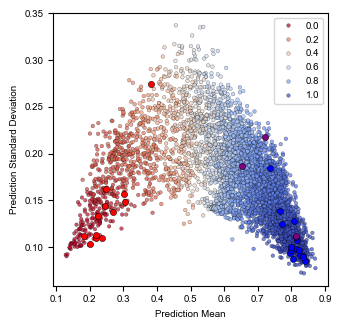

In [63]:
means = all_comp_preds[['uniprot','Protein name','pred','proba']].groupby(['uniprot','Protein name']).agg('mean')
stdevs = all_comp_preds[['uniprot','Protein name','pred','proba']].groupby(['uniprot','Protein name']).agg('std')
cvs = stdevs / means
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev').reset_index()
calcs


fig,ax = plt.subplots(figsize=[9*cm,9*cm])
sns.scatterplot(data=calcs,x='proba_mean',y='proba_stdev',hue='pred_mean',edgecolor='black',alpha=0.7,s=7,ax=ax,palette='coolwarm_r')

sns.scatterplot(data=calcs[(~calcs['Protein name'].isin(low)) & (calcs['Protein name'] != 'other')],x='proba_mean',y='proba_stdev',color='blue',edgecolor='black',alpha=1,s=20,ax=ax)
sns.scatterplot(data=calcs[calcs['Protein name'].isin(low)],x='proba_mean',y='proba_stdev',color='red',edgecolor='black',alpha=1,s=20,ax=ax)
sns.scatterplot(data=calcs[calcs['uniprot'].isin(successful_new_prots)],x='proba_mean',y='proba_stdev',color='purple',edgecolor='black',alpha=1,s=20,ax=ax)

# ax.get_legend().remove()
plt.xlabel('Prediction Mean')
plt.ylabel('Prediction Standard Deviation')
# plt.savefig(f'{fig_folder}/Fig5D-New-prots_mean_v_stdev_above_83_predictions.svg',format='svg',dpi=300)

plt.show()
# calcs.to_excel(f'{data_folder}/Fig5D-New-prots_above83_accuracy_predictions.xlsx')

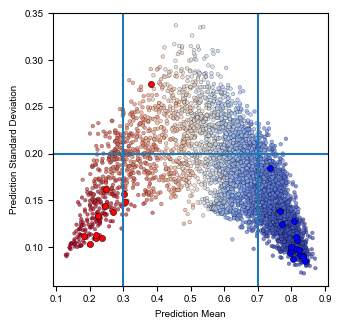

In [64]:
means = all_comp_preds[['uniprot','Protein name','pred','proba']].groupby(['uniprot','Protein name']).agg('mean')
stdevs = all_comp_preds[['uniprot','Protein name','pred','proba']].groupby(['uniprot','Protein name']).agg('std')
cvs = stdevs / means
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev').reset_index()
calcs


fig,ax = plt.subplots(figsize=[9*cm,9*cm])
sns.scatterplot(data=calcs,x='proba_mean',y='proba_stdev',hue='pred_mean',edgecolor='black',alpha=0.7,s=7,ax=ax,palette='coolwarm_r')

sns.scatterplot(data=calcs[(~calcs['Protein name'].isin(low)) & (calcs['Protein name'] != 'other')],x='proba_mean',y='proba_stdev',color='blue',edgecolor='black',alpha=1,s=20,ax=ax)
sns.scatterplot(data=calcs[calcs['Protein name'].isin(low)],x='proba_mean',y='proba_stdev',color='red',edgecolor='black',alpha=1,s=20,ax=ax)

ax.get_legend().remove()
plt.xlabel('Prediction Mean')
plt.ylabel('Prediction Standard Deviation')
plt.axvline(0.7)
plt.axvline(0.3)
plt.axhline(0.2)


# plt.savefig(f'{fig_folder}/Fig5E-mean_v_stdev_above_85_predictions.svg',format='svg',dpi=300)

plt.show()
# calcs.to_excel(f'{data_folder}/Fig5E-above85_accuracy_predictions.xlsx')

In [65]:
high = calcs[calcs['proba_stdev'] < 0.2]
good = len(high[high['proba_mean'] > 0.7])
bad = len(high[high['proba_mean'] < 0.3])

high_per = len(high) / len(calcs)
good_per = good / len(calcs)
bad_per = bad / len(calcs)
print(f'high:{round(high_per,3)} good:{round(good_per,3)} bad:{round(bad_per,3)}')


high:0.731 good:0.377 bad:0.059


In [67]:
paired_metrics[paired_metrics['accuracy'] > 0.83].sort_values('accuracy',ascending=False).head(20)

,pair_id,accuracy,precision,recall,tn,fp,fn,tp
104,104,0.882,0.894,0.900,103,17,16,144
101,101,0.857,0.853,0.906,95,25,15,145
100,100,0.854,0.836,0.925,91,29,12,148
20,20,0.850,0.843,0.906,93,27,15,145
46,46,0.850,0.878,0.856,101,19,23,137
89,89,0.846,0.893,0.831,104,16,27,133
31,31,0.839,0.853,0.869,96,24,21,139
47,47,0.839,0.836,0.894,92,28,17,143
49,49,0.836,0.848,0.869,95,25,21,139
64,64,0.836,0.839,0.881,93,27,19,141


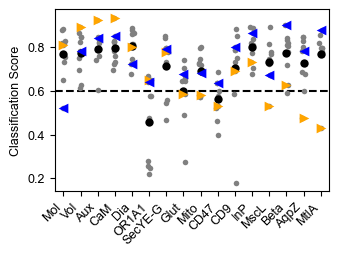

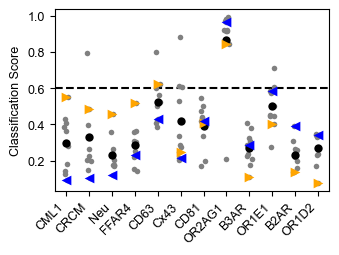

In [68]:
means = all_training_preds[['Protein name','pair_id','label','pred','proba']].groupby(['Protein name','pair_id']).agg('mean')
stdevs = all_training_preds[['Protein name','pair_id','label','pred','proba']].groupby(['Protein name','pair_id']).agg('std')
cvs = stdevs / means
training_calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev').reset_index()
training_calcs
best = training_calcs[training_calcs['pair_id'] == 104][['Protein name','proba_mean','label_mean']]
worst = training_calcs[training_calcs['pair_id'] == 64][['Protein name','proba_mean']]
diffs = best.merge(worst,on='Protein name')
diffs['diff'] = diffs['proba_mean_x'] - diffs['proba_mean_y']
order_1 = diffs[diffs['label_mean'] == 1].sort_values('diff')['Protein name'].tolist()
order_0 = diffs[diffs['label_mean'] == 0].sort_values('diff')['Protein name'].tolist()

plt.rcParams['font.size'] = 9

fig,ax = plt.subplots(figsize=[9*cm,6*cm])

sns.stripplot(data=training_calcs[training_calcs['label_mean'] == 1],x='Protein name',y='proba_mean',color='grey',order=order_1,s=size-2)
sns.stripplot(data=training_calcs[training_calcs['label_mean'] == 1].groupby('Protein name').agg('mean').reset_index(),x='Protein name',y='proba_mean',s=size,color='black',order=order_1)
sns.stripplot(data=training_calcs[training_calcs['pair_id'] == 64],x='Protein name',y='proba_mean', color='orange',s=7,order=order_1,marker='>')
sns.stripplot(data=training_calcs[training_calcs['pair_id'] == 104],x='Protein name',y='proba_mean', color='blue',s=7,order=order_1,marker='<')

# ax.get_legend().remove()
plt.axhline(0.6,c='k',ls='--')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Classification Score')
# plt.savefig(f'{fig_folder}/Supp_fig-all_classifier_preds_1.svg',format='svg',dpi=300)

plt.show()

fig,ax = plt.subplots(figsize=[9*cm,6*cm])

prot_order = training_calcs[training_calcs['label_mean'] == 0]['Protein name'].unique()
sns.stripplot(data=training_calcs[training_calcs['label_mean'] == 0],x='Protein name',y='proba_mean',color='grey',order=order_0,s=size-2)
sns.stripplot(data=training_calcs[training_calcs['label_mean'] == 0].groupby('Protein name').agg('mean').reset_index(),x='Protein name',y='proba_mean',s=size,color='black',order=order_0)
sns.stripplot(data=training_calcs[training_calcs['pair_id'] == 64],x='Protein name',y='proba_mean', color='orange',s=7,order=order_0,marker='>')
sns.stripplot(data=training_calcs[training_calcs['pair_id'] == 104],x='Protein name',y='proba_mean', color='blue',s=7,order=order_0,marker='<')

# ax.get_legend().remove()
plt.axhline(0.6,c='k',ls='--')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Classification Score')
# plt.savefig(f'{fig_folder}/Supp_fig-all_classifier_preds_0.svg',format='svg',dpi=300)

plt.show()

plt.rcParams['font.size'] = 7

In [69]:
training_calcs.set_index('Protein name').to_excel(f'{data_folder}/Supp_Fig_14-Ensemble_classifier_predictions.xlsx')

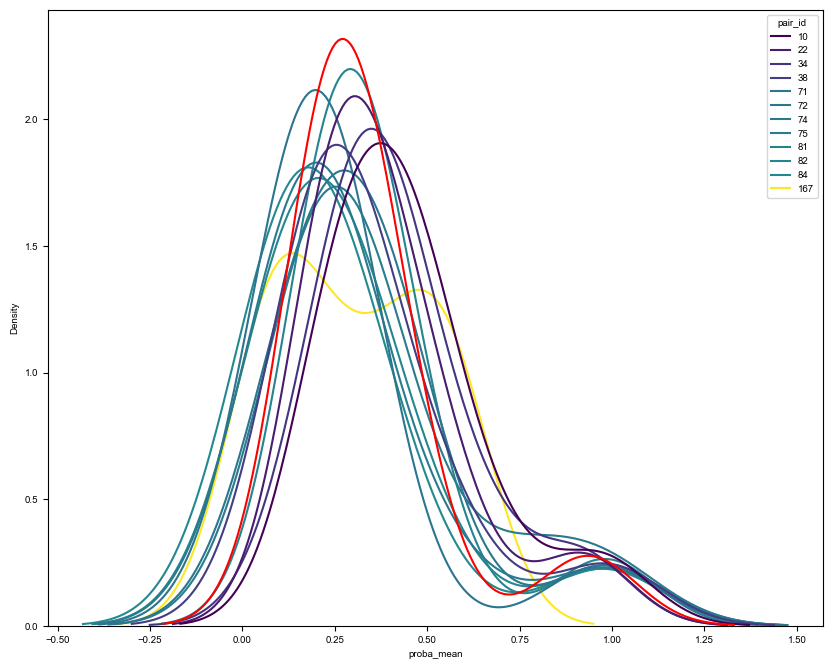

In [192]:
t = training_calcs[training_calcs['label_mean'] == 0]
sns.kdeplot(data=t,x='proba_mean',hue='pair_id',common_norm=False,palette='viridis')
sns.kdeplot(data=t.groupby('Protein name').agg(np.mean).reset_index(),x='proba_mean',color='red')

plt.show()

In [67]:
calcs = pd.read_excel(f'{data_folder}/Fig5E-above85_accuracy_predictions.xlsx')
calcs


,Unnamed: 0,uniprot,Protein name,pred_mean,proba_mean,pred_stdev,proba_stdev
0,0,A0A075B734,other,1.000,0.875,0.000,0.067
1,1,A0A087WTH1,other,0.843,0.751,0.364,0.196
2,2,A0A096LPK9,other,0.112,0.224,0.315,0.238
3,3,A0A0X1KG70,other,0.910,0.816,0.286,0.176
4,4,A0A1B0GTI8,other,0.282,0.396,0.450,0.260
...,...,...,...,...,...,...,...
4607,4607,Q9ZWB9,other,0.998,0.804,0.041,0.085
4608,4608,Q9ZWD1,other,0.872,0.790,0.335,0.212
4609,4609,Q9ZWG1,other,0.915,0.764,0.279,0.137
4610,4610,Q9ZWI7,other,0.933,0.834,0.250,0.200


#### Statistics

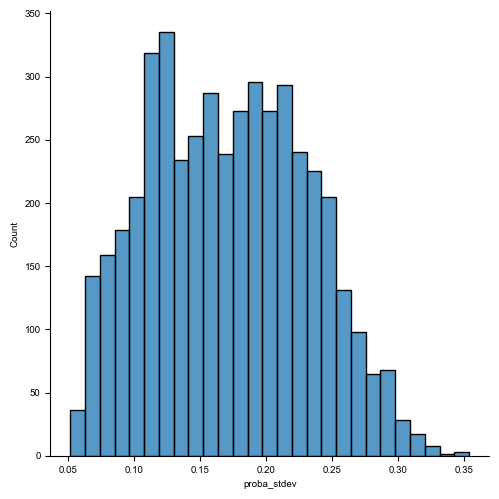

In [68]:
sns.displot(data=calcs,x='proba_stdev')
plt.show()

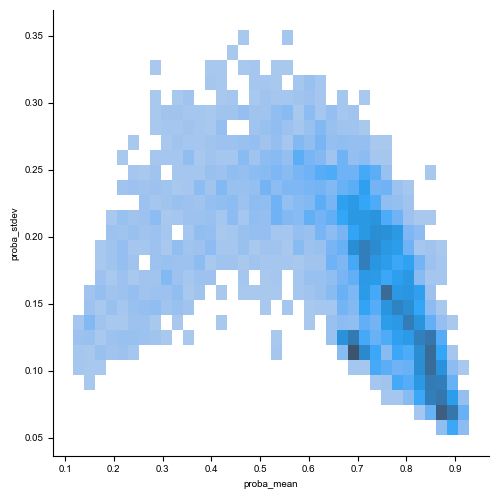

In [71]:
sns.displot(data=calcs,x='proba_mean',y='proba_stdev')

In [82]:
high = calcs[calcs['proba_stdev'] < 0.15]
good = len(high[high['proba_mean'] > 0.6])
bad = len(high[high['proba_mean'] < 0.4])

high_per = len(high) / len(calcs)
good_per = good / len(calcs)
bad_per = bad / len(calcs)
print(f'high:{round(high_per,3)} good:{round(good_per,3)} bad:{round(bad_per,3)}')


high:0.385 good:0.318 bad:0.031


In [83]:
high_std = calcs[calcs['proba_mean'] > 0.7]['proba_stdev'].mean()
low_std = calcs[calcs['proba_mean'] < 0.3]['proba_stdev'].mean()

high_std
low_std

0.1579517347134284